# Video next to Skeleton64 next to Skeleton20  

In [2]:
%reset -f
import csv
def custom_header_reader(file:'TextIOWrapper'):
    """
    Reads the qualisys .tsv headers
    """
    csvReader = csv.reader(file,delimiter='\t')
    for row, text in enumerate(csvReader):
        if row == 2: numMarkers = int(text[-1])
        elif row == 10: 
            columnNames = text[:-1]
            if columnNames[0] == 'Frame': 
                break
        elif row == 11: columnNames = text[:-1]; break
    return numMarkers, columnNames, csvReader

def line_reader(csvReader,fromSecond,toSecond):
    for line in csvReader:
        if fromSecond <= float(line[1]) <= toSecond:
            yield line[:len(columnNames)]
        elif float(line[1]) > toSecond:
            break

In [3]:
import pandas as pd
import os
import numpy as np

ANNOTATIONS_PATH = 'data'
REPROCESSED_PATH = ANNOTATIONS_PATH+'/reprocessed'
RAW_PATH = ANNOTATIONS_PATH+'/raw'
#annotations_file = ANNOTATIONS_PATH+'/annotationsVSingle.txt'
annotations_file = ANNOTATIONS_PATH+'/annotationsVExamples.txt' #'/annotationsVSingle.txt'

with open(annotations_file,'r') as file:
    annotations = file.read().splitlines()[1:]

sampleAnno = 1

if '(A)' in annotations[sampleAnno] or '(B)' in annotations[sampleAnno]:
    folder, trial, fragId, _, OoM, startSec, endSec = annotations[sampleAnno].replace(' ','').split(',')[:7]
else:
    folder, trial, fragId, OoM, startSec, endSec = annotations[sampleAnno].replace(' ','').split(',')[:6]

reprocessed_file = os.path.join(REPROCESSED_PATH, folder, trial+'_frag'+fragId+'.csv')
reducedMarkersTable = pd.read_csv(reprocessed_file)
#raw_file = os.path.join(RAW_PATH, folder, trial+'.tsv')
raw_file = os.path.join(ANNOTATIONS_PATH, folder, trial+'.tsv')
with open(raw_file,'r') as file:
    numMarkers, columnNames, readerBuffer = custom_header_reader(file)
    fullMarkersTable = pd.DataFrame(line_reader(readerBuffer,float(startSec),float(endSec)),columns=columnNames).astype(dict(zip(columnNames,[int,float,str]+[float]*len(columnNames[3:]))))
fullMarkersTable.iloc[:,3:] = (fullMarkersTable.iloc[:,3:] - fullMarkersTable.iloc[:,3:].min(axis=None))/(fullMarkersTable.iloc[:,3:].max(axis=None)-fullMarkersTable.iloc[:,3:].min(axis=None))
reducedMarkersTable.head()

,left_foot_X,left_foot_Y,left_foot_Z,right_foot_X,right_foot_Y,right_foot_Z,left_ank_X,left_ank_Y,left_ank_Z,right_ank_X,...,left_shoulder_Z,shoulder_center_X,shoulder_center_Y,shoulder_center_Z,right_shoulder_X,right_shoulder_Y,right_shoulder_Z,head_X,head_Y,head_Z
0,0.493254,0.430150,0.472700,0.351365,0.429746,0.470117,0.498598,0.440058,0.491266,0.348847,...,0.486884,0.425268,0.713362,0.486112,0.396480,0.713861,0.485340,0.426332,0.754957,0.479995
1,0.493259,0.430151,0.472702,0.351366,0.429746,0.470115,0.498595,0.440058,0.491266,0.348848,...,0.486879,0.425267,0.713369,0.486095,0.396474,0.713866,0.485310,0.426336,0.754965,0.479984
2,0.493266,0.430152,0.472704,0.351366,0.429747,0.470113,0.498592,0.440059,0.491265,0.348849,...,0.486876,0.425267,0.713378,0.486079,0.396468,0.713872,0.485282,0.426339,0.754974,0.479976
3,0.493273,0.430153,0.472705,0.351365,0.429748,0.470110,0.498591,0.440060,0.491264,0.348851,...,0.486876,0.425268,0.713389,0.486065,0.396463,0.713878,0.485254,0.426342,0.754981,0.479970
4,0.493281,0.430154,0.472705,0.351364,0.429749,0.470106,0.498590,0.440061,0.491262,0.348852,...,0.486877,0.425269,0.713401,0.486052,0.396458,0.713885,0.485227,0.426346,0.754987,0.479962


# WDC Examples

In [4]:
physToIdx = {'Lfoot':2,'Rfoot':1,'Lank':4,'Rank':3,'Lknee':6,'Rknee':5,'Lhip':9,'Chip':8,'Rhip':7,'spine':10,'Lhand':12,'Rhand':11,'Lwrist':14,'Rwrist':13,'Lelbow':16,'Relbow':15,'Lshoulder':19,'Cshoulder':18,'Rshoulder':17,'head':20}
indxToPhys = {v: k for k, v in physToIdx.items()}
def map_pos_human_body_graph():
    return {
        physToIdx['head']: [0,1],
        physToIdx['Cshoulder']: [0,0.7],
        physToIdx['Rshoulder']: [-0.55,0.65],
        physToIdx['Lshoulder']: [0.55,0.65],
        physToIdx['Relbow']: [-0.70,0.35],
        physToIdx['Lelbow']: [0.70,0.35],
        physToIdx['Rwrist']: [-0.80,0.03],
        physToIdx['Lwrist']: [0.80,0.03],
        physToIdx['Rhand']: [-1,-0.2],
        physToIdx['Lhand']: [1,-0.2],
        physToIdx['spine']: [0,0.3],
        physToIdx['Chip']: [0,0],
        physToIdx['Rhip']: [-0.4,-0.2],
        physToIdx['Lhip']: [0.4,-0.2],
        physToIdx['Rknee']: [-0.45,-0.55],
        physToIdx['Lknee']: [0.45,-0.55],
        physToIdx['Rank']: [-0.5,-0.85],
        physToIdx['Lank']: [0.5,-0.85],
        physToIdx['Rfoot']: [-0.78,-1],
        physToIdx['Lfoot']: [0.78,-1]
    }

In [5]:
from clustering import *

posTable = reducedMarkersTable

dt = ((float(endSec)-float(startSec)) / len(posTable))
velocityTable = group_table_by_joints(compute_derivatives(posTable,dt)).applymap(lambda x: np.linalg.norm(x))

accelerationTable = compute_derivatives(velocityTable,dt)

centerOfMassPosTable = pd.concat([table.apply(lambda row: row.sum()/20,axis=1) for table in table_to_list_xyz_tables(posTable)],axis=1)
relativePosTable = group_table_by_joints(xyz_tables_to_xyz_columns([posTableAxis.subtract(centerOfMassPosTable.iloc[:,j],axis=0) for j,posTableAxis in enumerate(table_to_list_xyz_tables(posTable))]))
centerOfMassVelocityTable = compute_derivatives(centerOfMassPosTable,dt,smooth=False)
relativeVelocityTable = group_table_by_joints(xyz_tables_to_xyz_columns([velocityTableAxis.subtract(centerOfMassVelocityTable.iloc[:,j],axis=0) for j,velocityTableAxis in enumerate(table_to_list_xyz_tables(compute_derivatives(posTable,dt)))]))
angularMomentumTable = relativePosTable
relativePosTable.head()
for i in range(len(relativePosTable)):
    for j in range(len(relativePosTable.columns)):
        angularMomentumTable.iloc[i,j][:] = np.cross(relativePosTable.iloc[i,j],relativeVelocityTable.iloc[i,j])
angularMomentumTable = group_table_by_joints(smoothing(joints_array_to_xyz_columns(angularMomentumTable)))
angularMomentumTable.head()

,left_foot,right_foot,left_ank,right_ank,left_knee,right_knee,left_hip,hip_central,right_hip,spine,left_hand,right_hand,left_wrist,right_wrist,left_elbow,right_elbow,left_shoulder,shoulder_center,right_shoulder,head
0,"[-0.0002183705209839509, -7.782780416311073e-0...","[-0.00017737026408525626, 6.98664404665903e-05...","[-0.0001985545046570996, -8.013316654383104e-0...","[-0.00016749782197726873, 6.787907688333036e-0...","[-0.00014766552228802978, -5.616418353253574e-...","[-5.339499760547187e-05, 1.904320406111517e-05...","[-1.4701214562324748e-06, -1.6080896401493874e...","[-1.3821723935146318e-06, -4.8559481072346e-08...","[-4.852027969033681e-07, 3.064193218500849e-06...","[-4.8014937692754545e-06, -1.2584209434537203e...","[0.0002682151063579541, -0.0004749787314298268...","[-0.0005055116719318508, -0.000726644870068420...","[0.00020648299915956874, -0.000293777300559310...","[-0.00033051937808209106, -0.00042727229783483...","[0.00011375390212599617, -0.000127645837273498...","[-0.000260659857221144, -0.0002638532369768832...","[3.4052105821709914e-05, -1.65162752343166e-05...","[-5.1635736521928396e-05, -3.056799424134114e-...","[-0.000137836813386898, -4.582840408982688e-05...","[-0.00025406834725571006, 4.512153669787232e-0..."
1,"[-0.00021975137668081888, -7.830726242031372e-...","[-0.00017979154355613952, 7.066697559604642e-0...","[-0.00019994109755684615, -8.062919010255675e-...","[-0.0001692241616058343, 6.881464111909215e-05...","[-0.0001466665982464608, -5.5802492890801435e-...","[-5.3441975652578034e-05, 1.8990871036237644e-...","[-1.44460578213265e-06, -1.5841475793184446e-0...","[-1.3427511530781348e-06, -4.464252494278567e-...","[-4.2972777310424015e-07, 2.751509077029583e-0...","[-5.155342735678462e-06, -1.2960409273499011e-...","[0.00026721074228658, -0.0004730998039026127, ...","[-0.0004968637139790485, -0.000714777292506725...","[0.00020578396855850113, -0.000293078278027202...","[-0.0003245698428790392, -0.000419690950469281...","[0.00011422922131803285, -0.000128344808092426...","[-0.0002564055529545646, -0.000259564506031372...","[3.316432981247923e-05, -1.6229204885973665e-0...","[-5.139761029005219e-05, -3.0125906134370503e-...","[-0.00013651242903252049, -4.532218270684014e-...","[-0.0002583695090662455, 4.531695620916126e-06..."
2,"[-0.0002209481182847711, -7.869939878621693e-0...","[-0.0001818985033612434, 7.136538953441116e-05...","[-0.00020089412480252025, -8.102244496801264e-...","[-0.00017080065169512848, 6.96333166490089e-05...","[-0.0001452568872231574, -5.528108040984198e-0...","[-5.331056750619913e-05, 1.885153946031244e-05...","[-1.410702194828814e-06, -1.5514028131006284e-...","[-1.291649518019141e-06, -4.0066210558616386e-...","[-3.6045794296359123e-07, 2.3641115708206345e-...","[-5.6107050350874935e-06, -1.332861789448902e-...","[0.00026587205040422767, -0.000470624126776726...","[-0.00048796305236275135, -0.00070258654152234...","[0.00020471513978910242, -0.000291851758841216...","[-0.000318019372560436, -0.0004113094129898091...","[0.00011464116461779795, -0.000128950582802163...","[-0.0002520282815529286, -0.000255140010284114...","[3.1956373765802925e-05, -1.5836285873401312e-...","[-5.1386594372908915e-05, -2.974276310832929e-...","[-0.00013529661075029398, -4.485509584246617e-...","[-0.0002640892750400842, 4.568588118117696e-06..."
3,"[-0.0002219952671882293, -7.904177307920806e-0...","[-0.00018379508821193615, 7.198679811286619e-0...","[-0.00020172802364248508, -8.136654297528657e-...","[-0.0001721800805232609, 7.035463847170377e-05...","[-0.00014341977008282988, -5.459407183276552e-...","[-5.314015317972942e-05, 1.8680684445867883e-0...","[-1.3705595033393587e-06, -1.5117997857058793e...","[-1.2314745607998244e-06, -3.508216208161952e-...","[-2.803568633644255e-07, 1.9193577965006964e-0...","[-6.135984160449526e-06, -1.3650800437855278e-...","[0.00026432074458923816, -0.000467763785267506...","[-0.00047880874187466527, -0.00069009084122496...","[0.00020327914262605263, -0.000

In [6]:
from clustering import *
import os
from PIL import Image, ImageOps

def save_fig(fig,i, crop=True):
    # Get the figure's canvas and render it
    fig.canvas.draw()

    # Get the width and height of the figure
    width, height = fig.canvas.get_width_height()

    # Convert the canvas to a NumPy array of pixels
    pixels = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape((height, width, 3))

    # Open the image
    input_image = Image.fromarray(pixels)  # Replace with your image file

    # Convert the image to grayscale for intensity comparison
    grayscale_image = ImageOps.invert(input_image.convert('L'))

    # Get the bounding box of the non-white area
    non_white_box = grayscale_image.getbbox(alpha_only=False)

    if crop:
        # Crop the image using the non-white bounding box
        cropped_image = input_image.crop(non_white_box)
    else: cropped_image = input_image

    # Save or display the cropped image
    cropped_image.save(os.path.join('_wdc',f'_cropped_fig{str(i)}.png'))  # Save the cropped image
    
# 224, 226, 231!, 265 - 275
timeInstant = 720
figsize = (16,23)

jointsFrom = [1, 3, 5, 7, 2, 4, 6, 9, 8,10,11,13,15,17,12,14,16,19,18]
jointsTo =   [3, 5, 7, 8, 4, 6, 9, 8,10,18,13,15,17,18,14,16,19,18,20]
allNodes = set(jointsFrom).union(set(jointsTo))
jointsFrom = list(map(lambda x: x-1,jointsFrom))
jointsTo = list(map(lambda x: x-1,jointsTo))
edges = np.array(list(zip(jointsFrom,jointsTo))+list(zip(jointsTo,jointsFrom)))

adjacencyMatrix = np.zeros((20,20),dtype=bool)
adjacencyMatrix[edges[:,0],edges[:,1]] = True

featuresTable = velocityTable
#print(velocityTable)
# using angular momentum vector as feature
if isinstance(featuresTable.iloc[0,0],np.ndarray):
    tol = None
# using norm of either velocity / acceleration / energy as feature
else:
    tol = featuresTable.mean(axis=None) * 10**-3
    
weightMatrix = calculate_weight_matrix(featuresTable.iloc[timeInstant],adjacencyMatrix,tol)
predicted_labels = shi_malik_spectral_clustering_matlab_version(weightMatrix,3)
weightMatrixAux = compute_auxiliary_graph(featuresTable.iloc[timeInstant],predicted_labels,adjacencyMatrix)

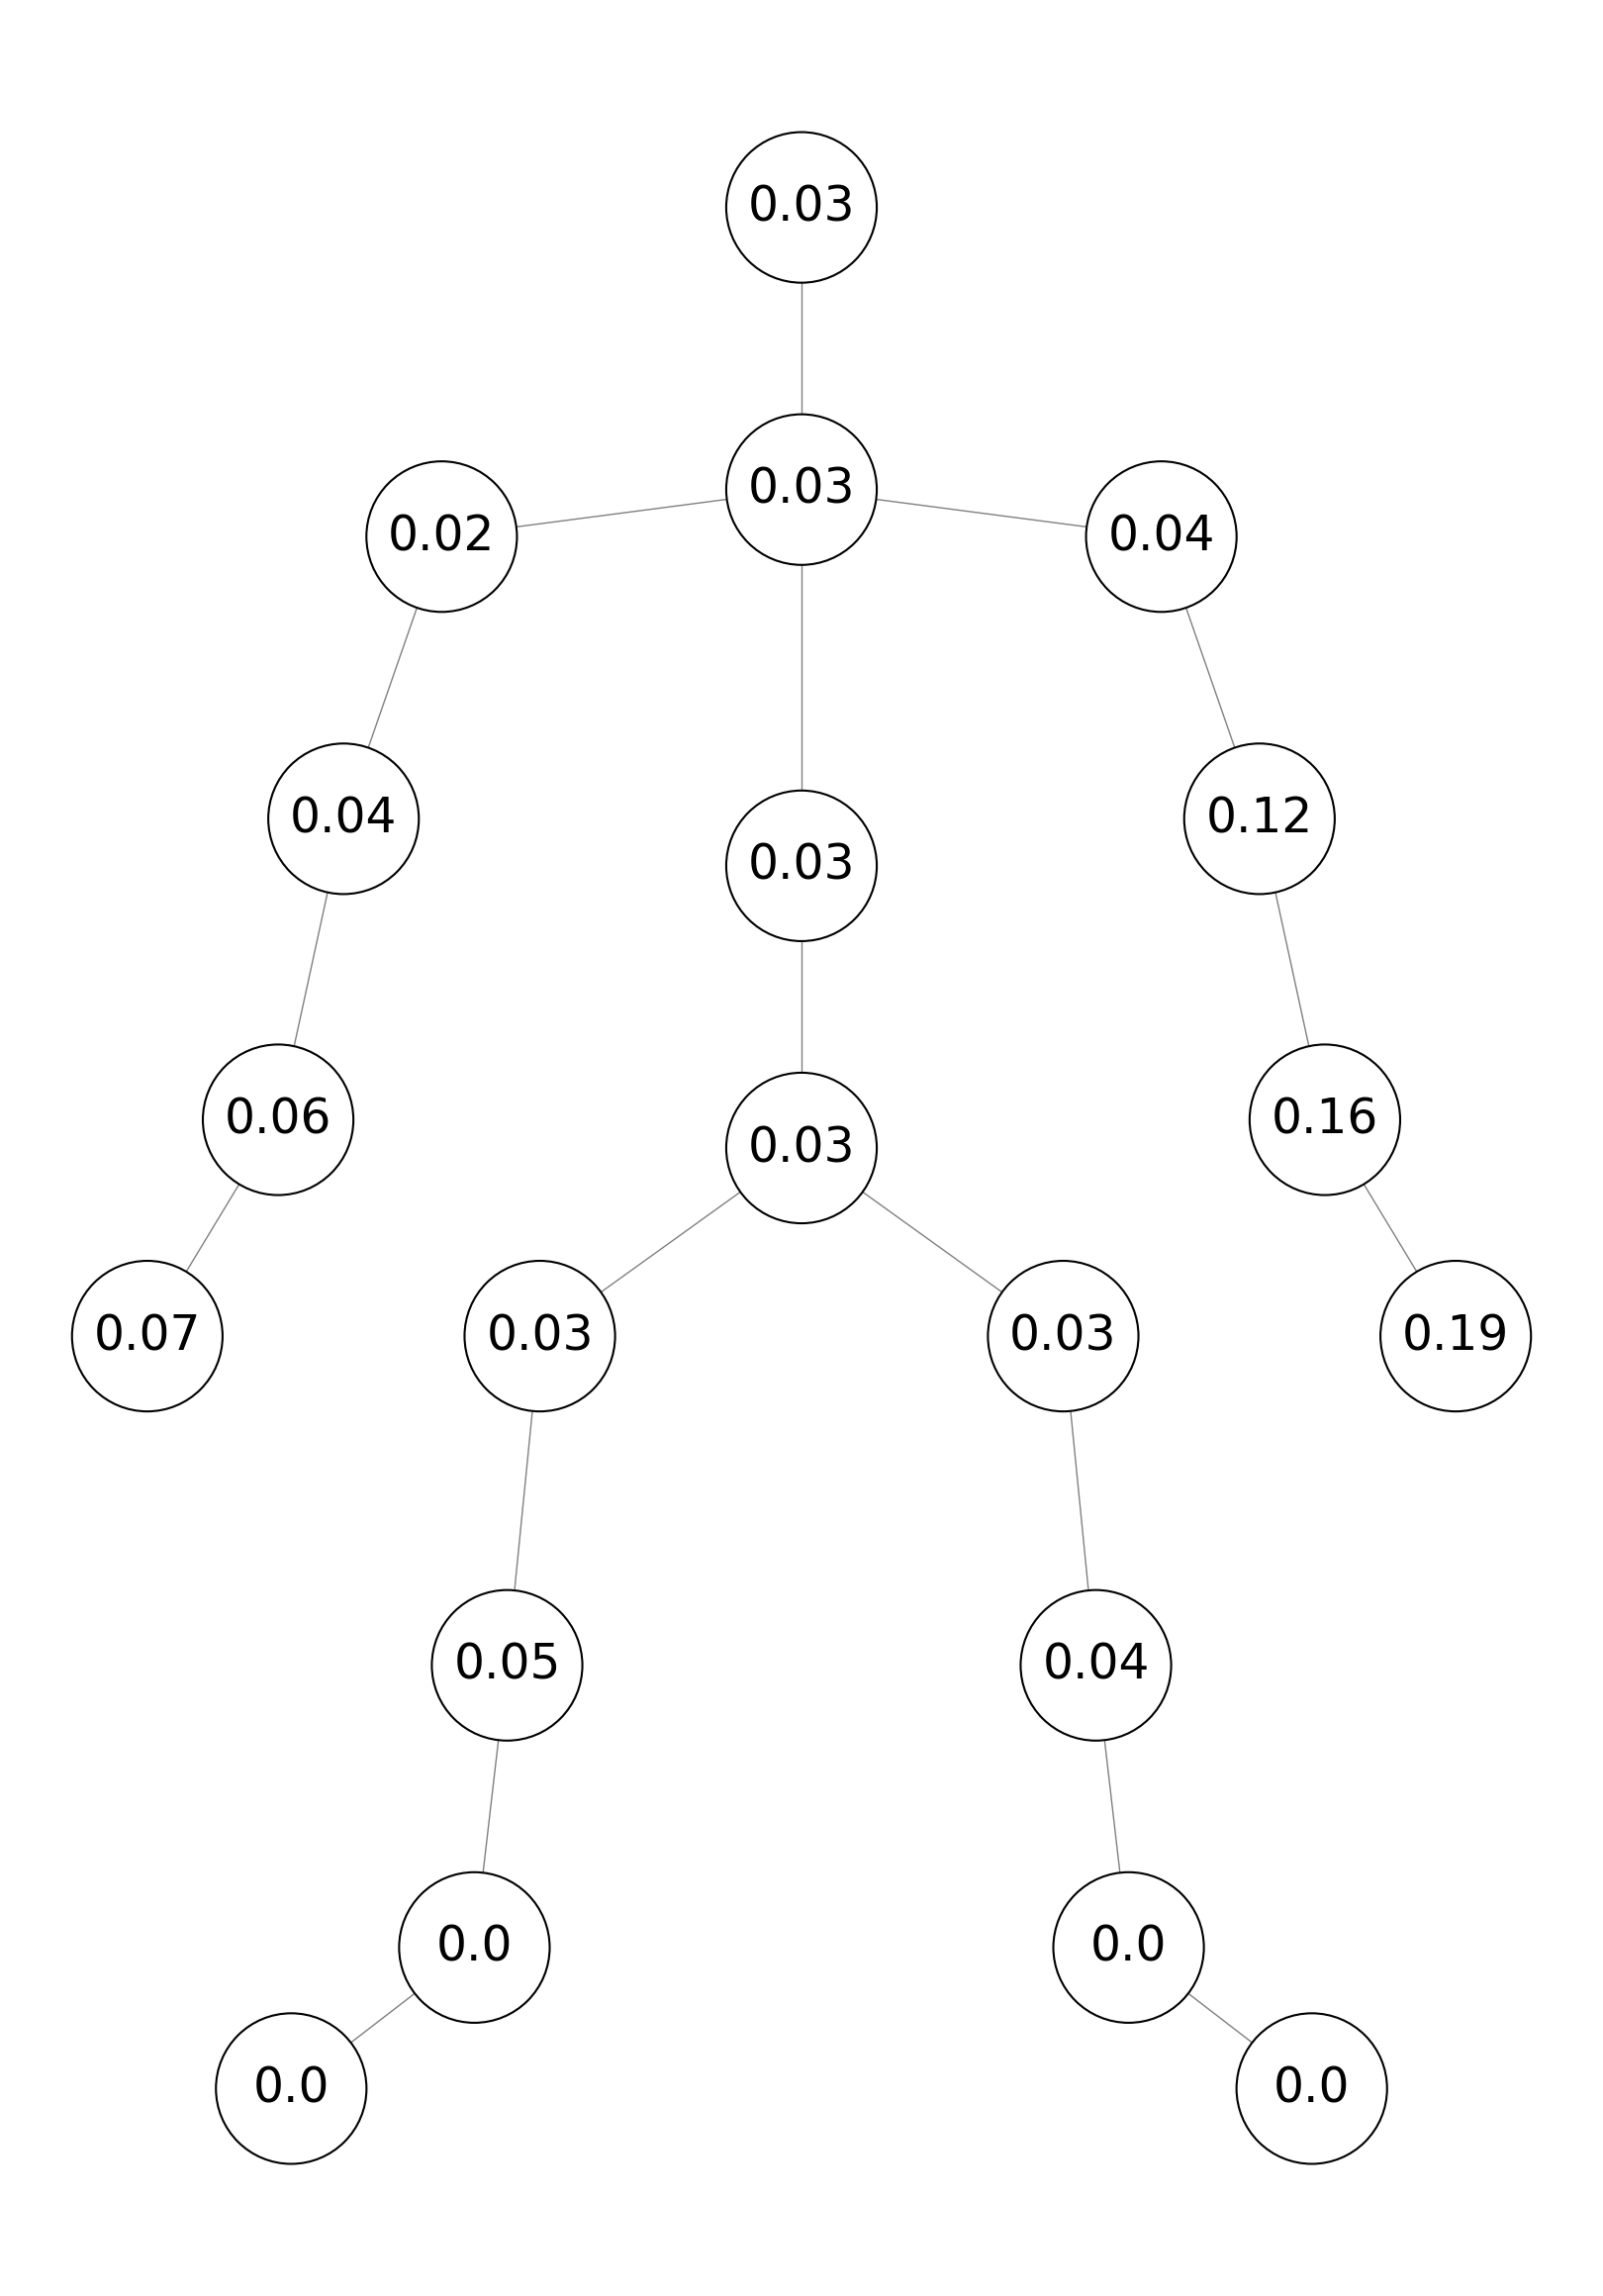

In [7]:
import networkx as nx
%matplotlib inline

# Create a graph using NetworkX from the adjacency matrix
graph = nx.from_numpy_array(np.multiply(adjacencyMatrix,weightMatrix))


# Create a dictionary with the new labels for the nodes
labels = {node: str(round(featuresTable.iloc[timeInstant, i], 2)) for i, node in enumerate(graph.nodes())}

# Set the new labels as node attributes
nx.set_node_attributes(graph, labels, 'node_weight')

graph = nx.relabel_nodes(graph, {node: list(allNodes)[i] for i,node in enumerate(graph.nodes())})

# Get the new labels from the node attributes
labels = nx.get_node_attributes(graph, 'node_weight')

# Get edge labels from adjacency matrix (if present)
edge_labels = nx.get_edge_attributes(graph, "weight")
# Clip edge weights to the 2nd decimal place
for edge, weight in edge_labels.items():
    edge_labels[edge] = round(weight, 2)

pos = map_pos_human_body_graph()

# Use the color pool to map cluster labels to colors
node_colors = [(1,1,1)]*20#[(68/255,114/255,196/255)]*len(predicted_labels)#[color_pool[label % len(color_pool)] for label in predicted_labels]

fig = plt.figure(figsize=figsize)
#canvas = fig.canvas
nx.draw(graph, 
        pos, 
        labels=labels, 
        with_labels=True, 
        node_size=12000, 
        node_color=node_colors, 
        edge_color="gray",
        font_size=35,
        node_shape="o",  # Set node shape to circular
        linewidths=1.5,  # Set the width of node border
        edgecolors='k')  # Set the node border color)#,font_weight='bold')
#nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=20, font_color='gray', label_pos=0.5)
save_fig(fig,0)

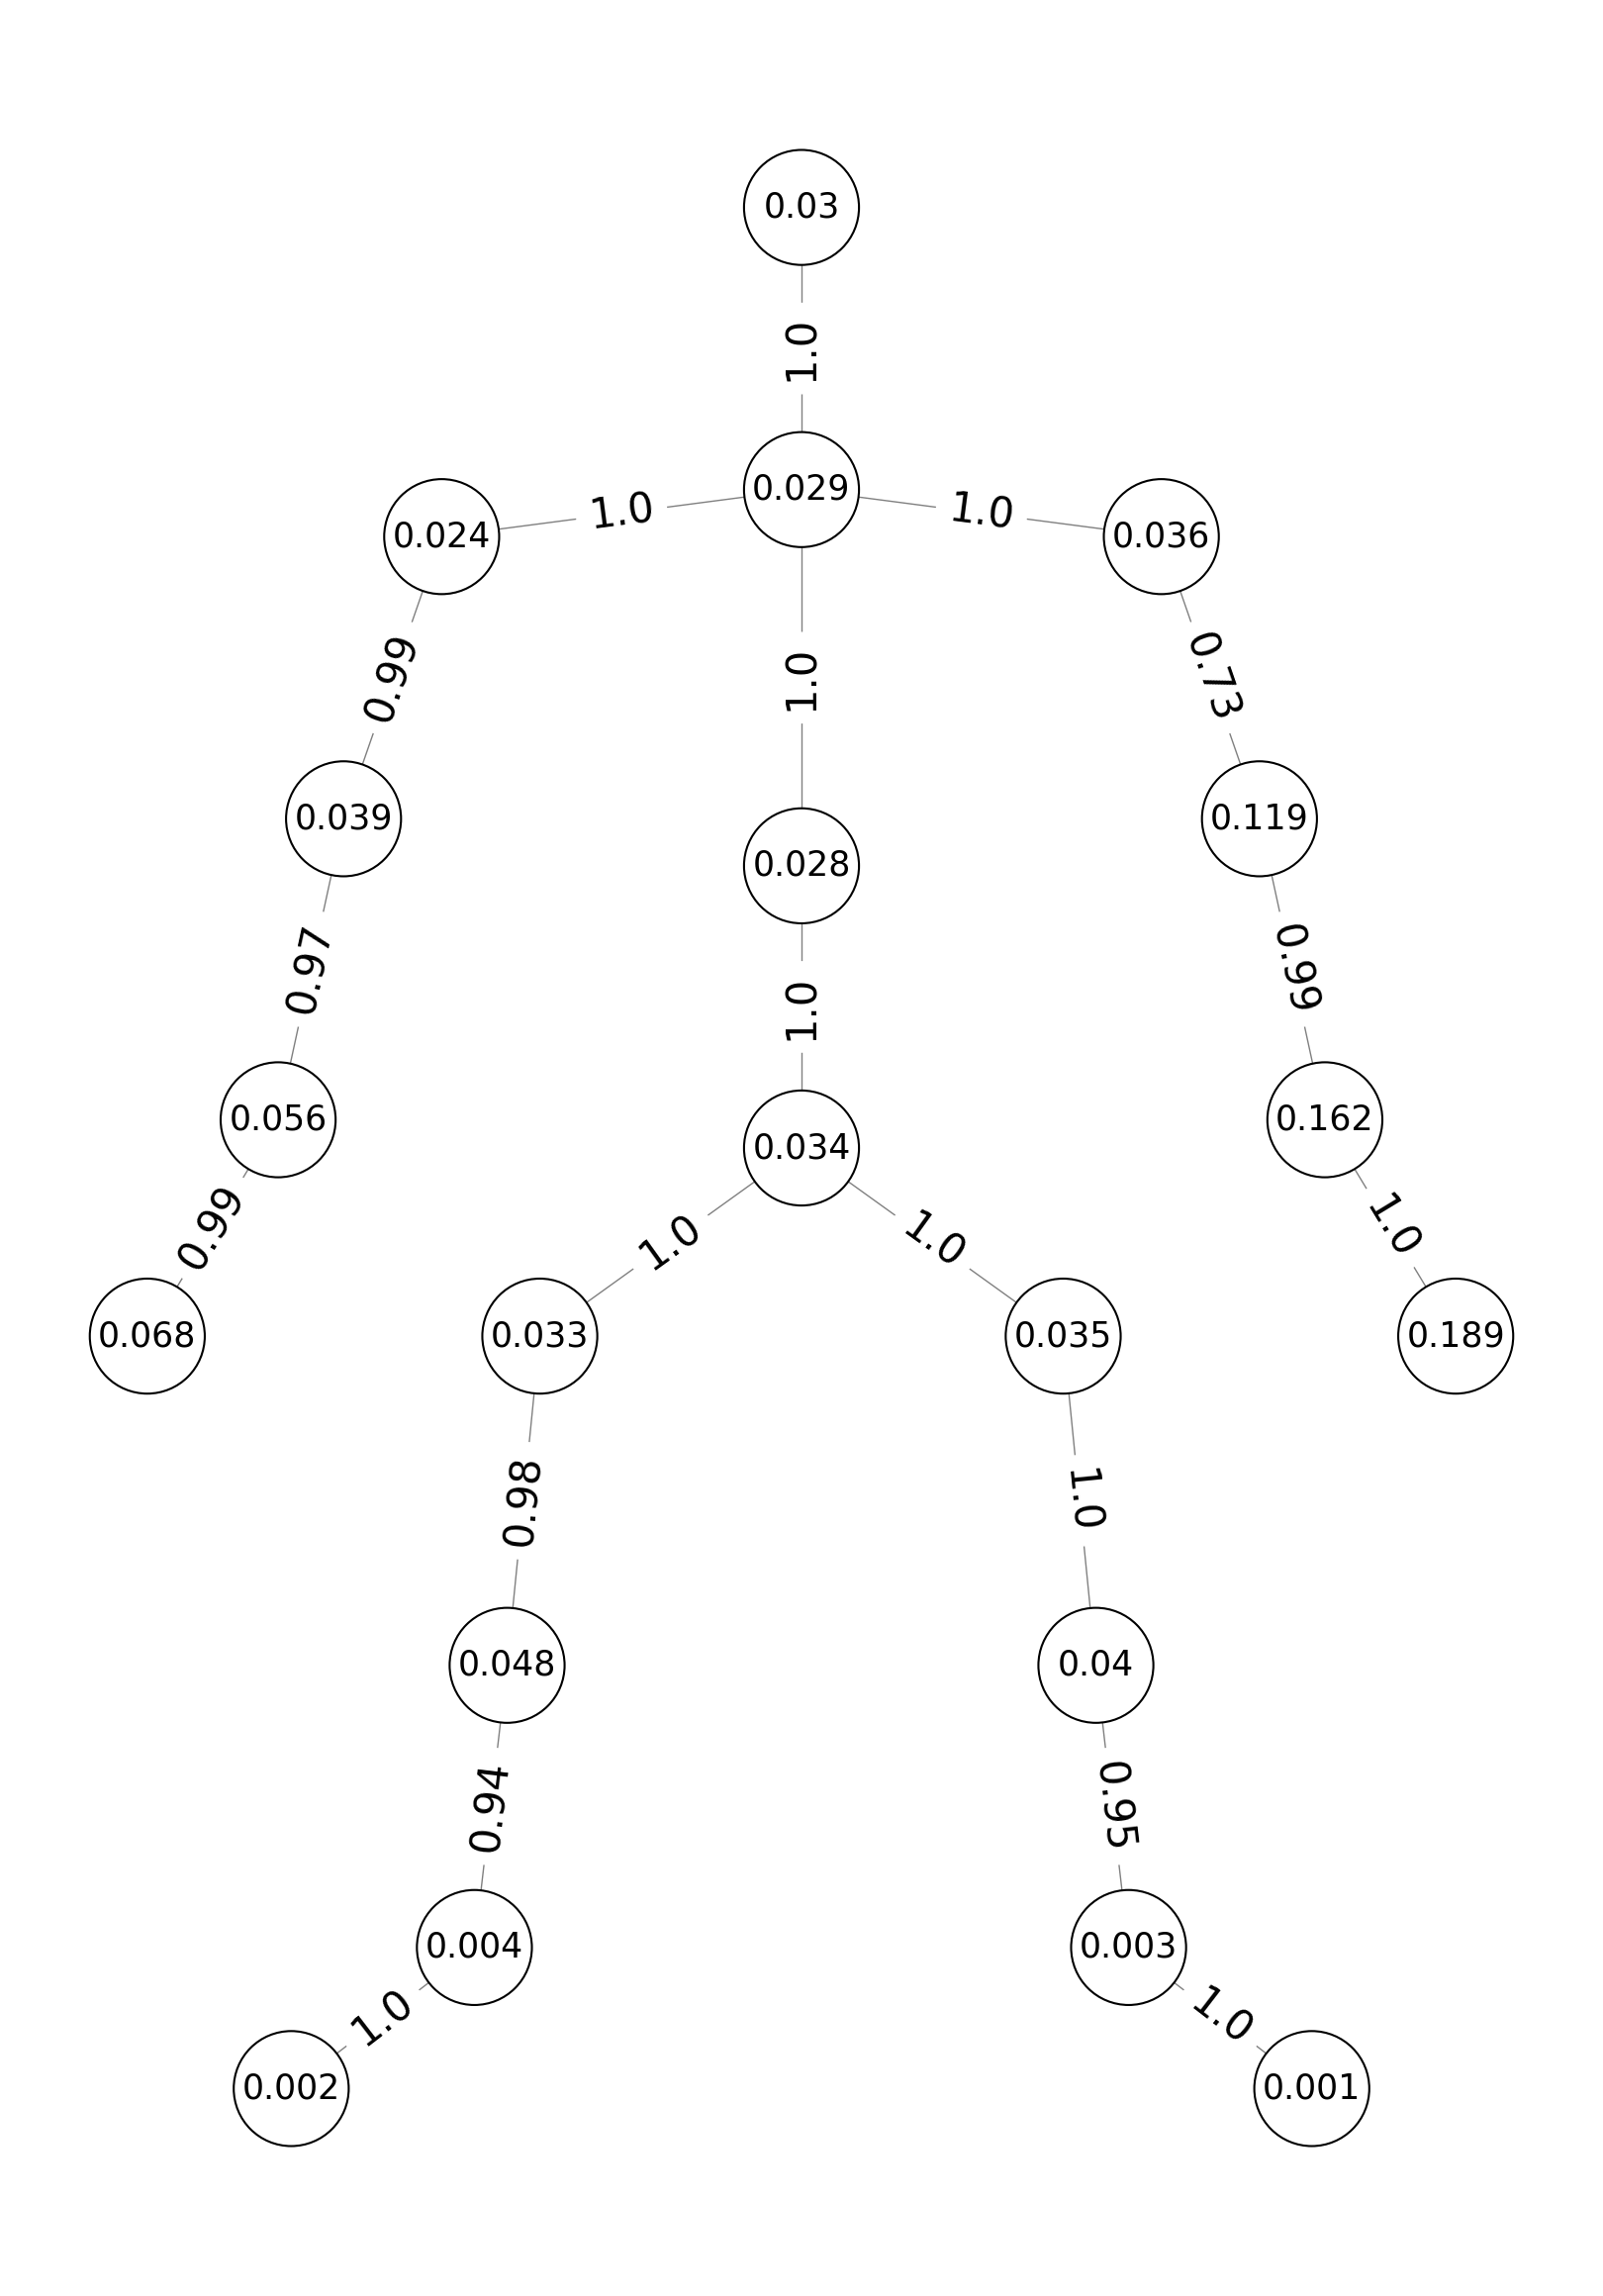

In [8]:
import networkx as nx
from clustering import *
%matplotlib inline

# Create a graph using NetworkX from the adjacency matrix
graph = nx.from_numpy_array(np.multiply(adjacencyMatrix,weightMatrix/2))


# Create a dictionary with the new labels for the nodes
labels = {node: str(round(featuresTable.iloc[timeInstant, i], 3)) for i, node in enumerate(graph.nodes())}

# Set the new labels as node attributes
nx.set_node_attributes(graph, labels, 'node_weight')

graph = nx.relabel_nodes(graph, {node: list(allNodes)[i] for i,node in enumerate(graph.nodes())})

# Get the new labels from the node attributes
labels = nx.get_node_attributes(graph, 'node_weight')

# Get edge labels from adjacency matrix (if present)
edge_labels = nx.get_edge_attributes(graph, "weight")
# Clip edge weights to the 2nd decimal place
for edge, weight in edge_labels.items():
    edge_labels[edge] = round(weight, 2)

pos = map_pos_human_body_graph()

# Use the color pool to map cluster labels to colors
node_colors = [(1,1,1)]*20#[(68/255,114/255,196/255)]*len(predicted_labels)#[color_pool[label % len(color_pool)] for label in predicted_labels]

fig = plt.figure(figsize=figsize)
#canvas = fig.canvas
nx.draw(graph, 
        pos, 
        labels=labels, 
        with_labels=True, 
        node_size=7000, 
        node_color=node_colors, 
        edge_color="gray",
        font_size=25,
        node_shape="o",  # Set node shape to circular
        linewidths=1.5,  # Set the width of node border
        edgecolors='k')  # Set the node border color)#,font_weight='bold')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=30, font_color='k', label_pos=0.5)
save_fig(fig,1)

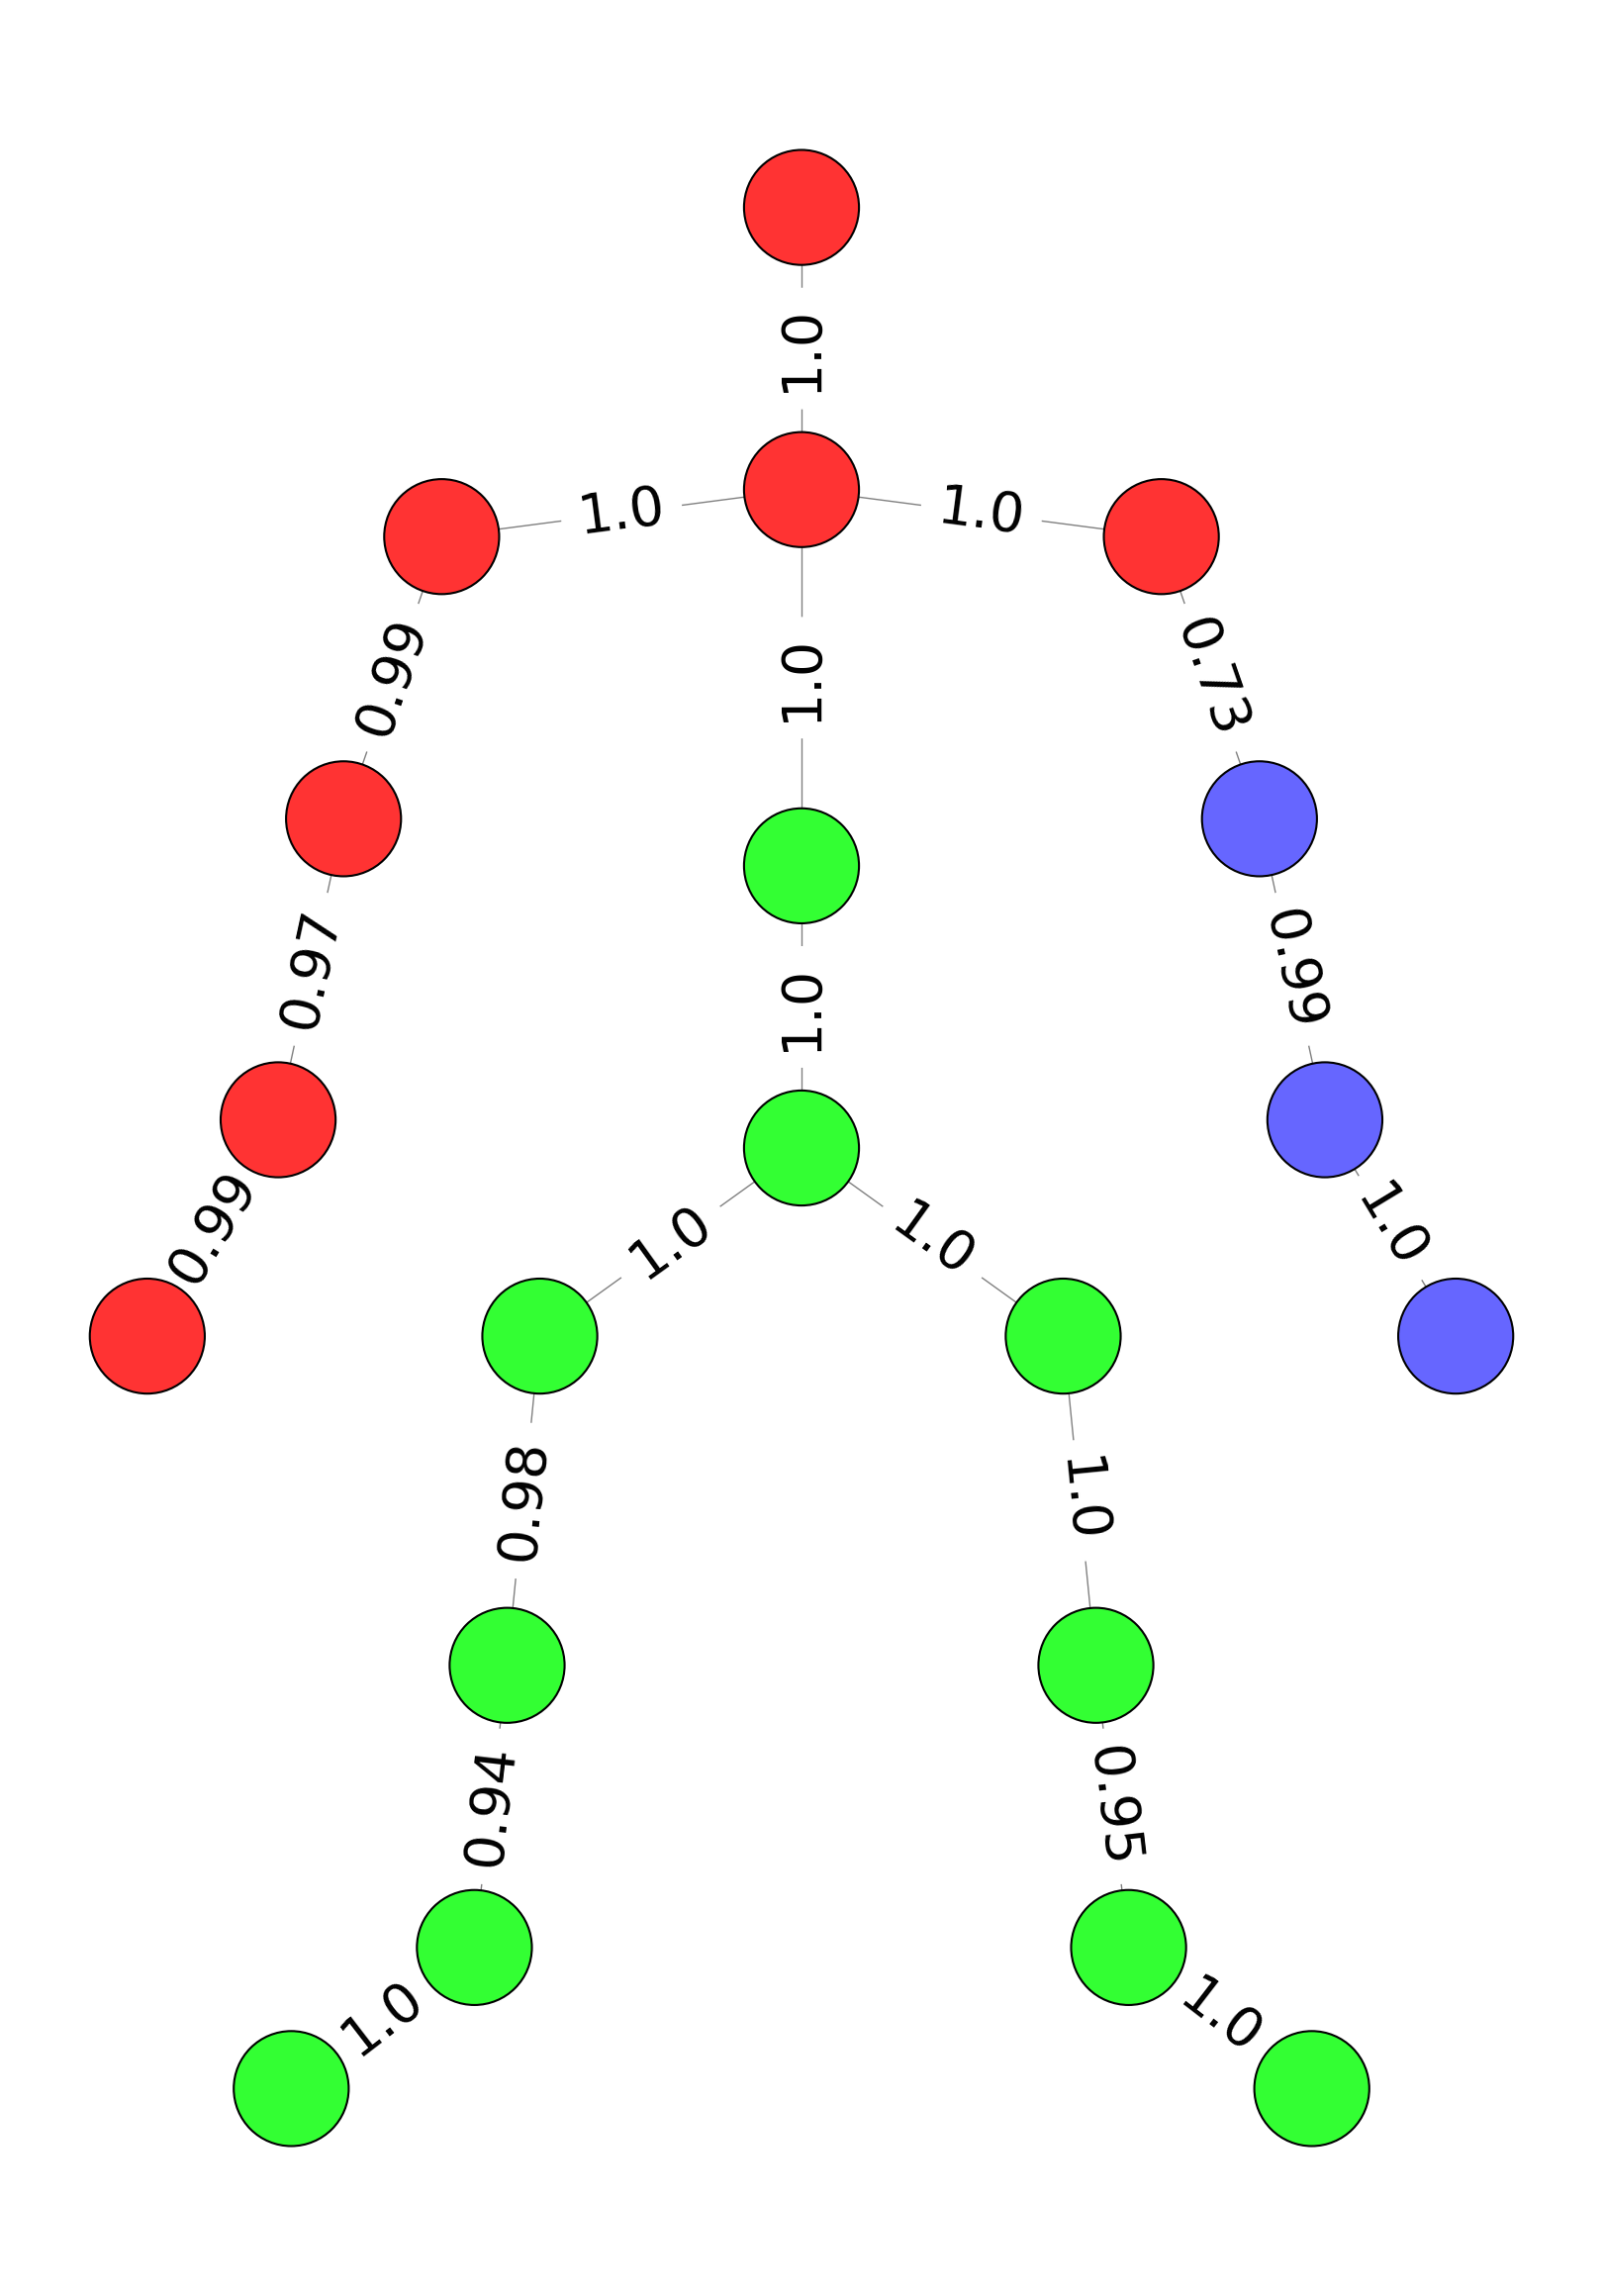

In [9]:
import networkx as nx
from clustering import *
%matplotlib inline

# Create a graph using NetworkX from the adjacency matrix
graph = nx.from_numpy_array(np.multiply(adjacencyMatrix,weightMatrix/2))


# Create a dictionary with the new labels for the nodes
labels = {node: str(round(featuresTable.iloc[timeInstant, i], 3)) for i, node in enumerate(graph.nodes())}

# Set the new labels as node attributes
nx.set_node_attributes(graph, labels, 'node_weight')

graph = nx.relabel_nodes(graph, {node: list(allNodes)[i] for i,node in enumerate(graph.nodes())})

# Get the new labels from the node attributes
labels = nx.get_node_attributes(graph, 'node_weight')

# Get edge labels from adjacency matrix (if present)
edge_labels = nx.get_edge_attributes(graph, "weight")
# Clip edge weights to the 2nd decimal place
for edge, weight in edge_labels.items():
    edge_labels[edge] = round(weight, 2)

pos = map_pos_human_body_graph()

color_pool = [(1,0.2,0.2),(0.2,1,0.2),(0.4,0.4,1)]

# Use the color pool to map cluster labels to colors
node_colors = [color_pool[label % len(color_pool)] for label in predicted_labels]

fig = plt.figure(figsize=figsize)
#canvas = fig.canvas
nx.draw(graph, 
        pos, 
        labels=labels, 
        with_labels=False, 
        node_size=7000, 
        node_color=node_colors, 
        edge_color="gray",
        font_size=25,
        node_shape="o",  # Set node shape to circular
        linewidths=1.5,  # Set the width of node border
        edgecolors='k')  # Set the node border color)#,font_weight='bold')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=40, font_color='k', label_pos=0.5)
save_fig(fig,2)

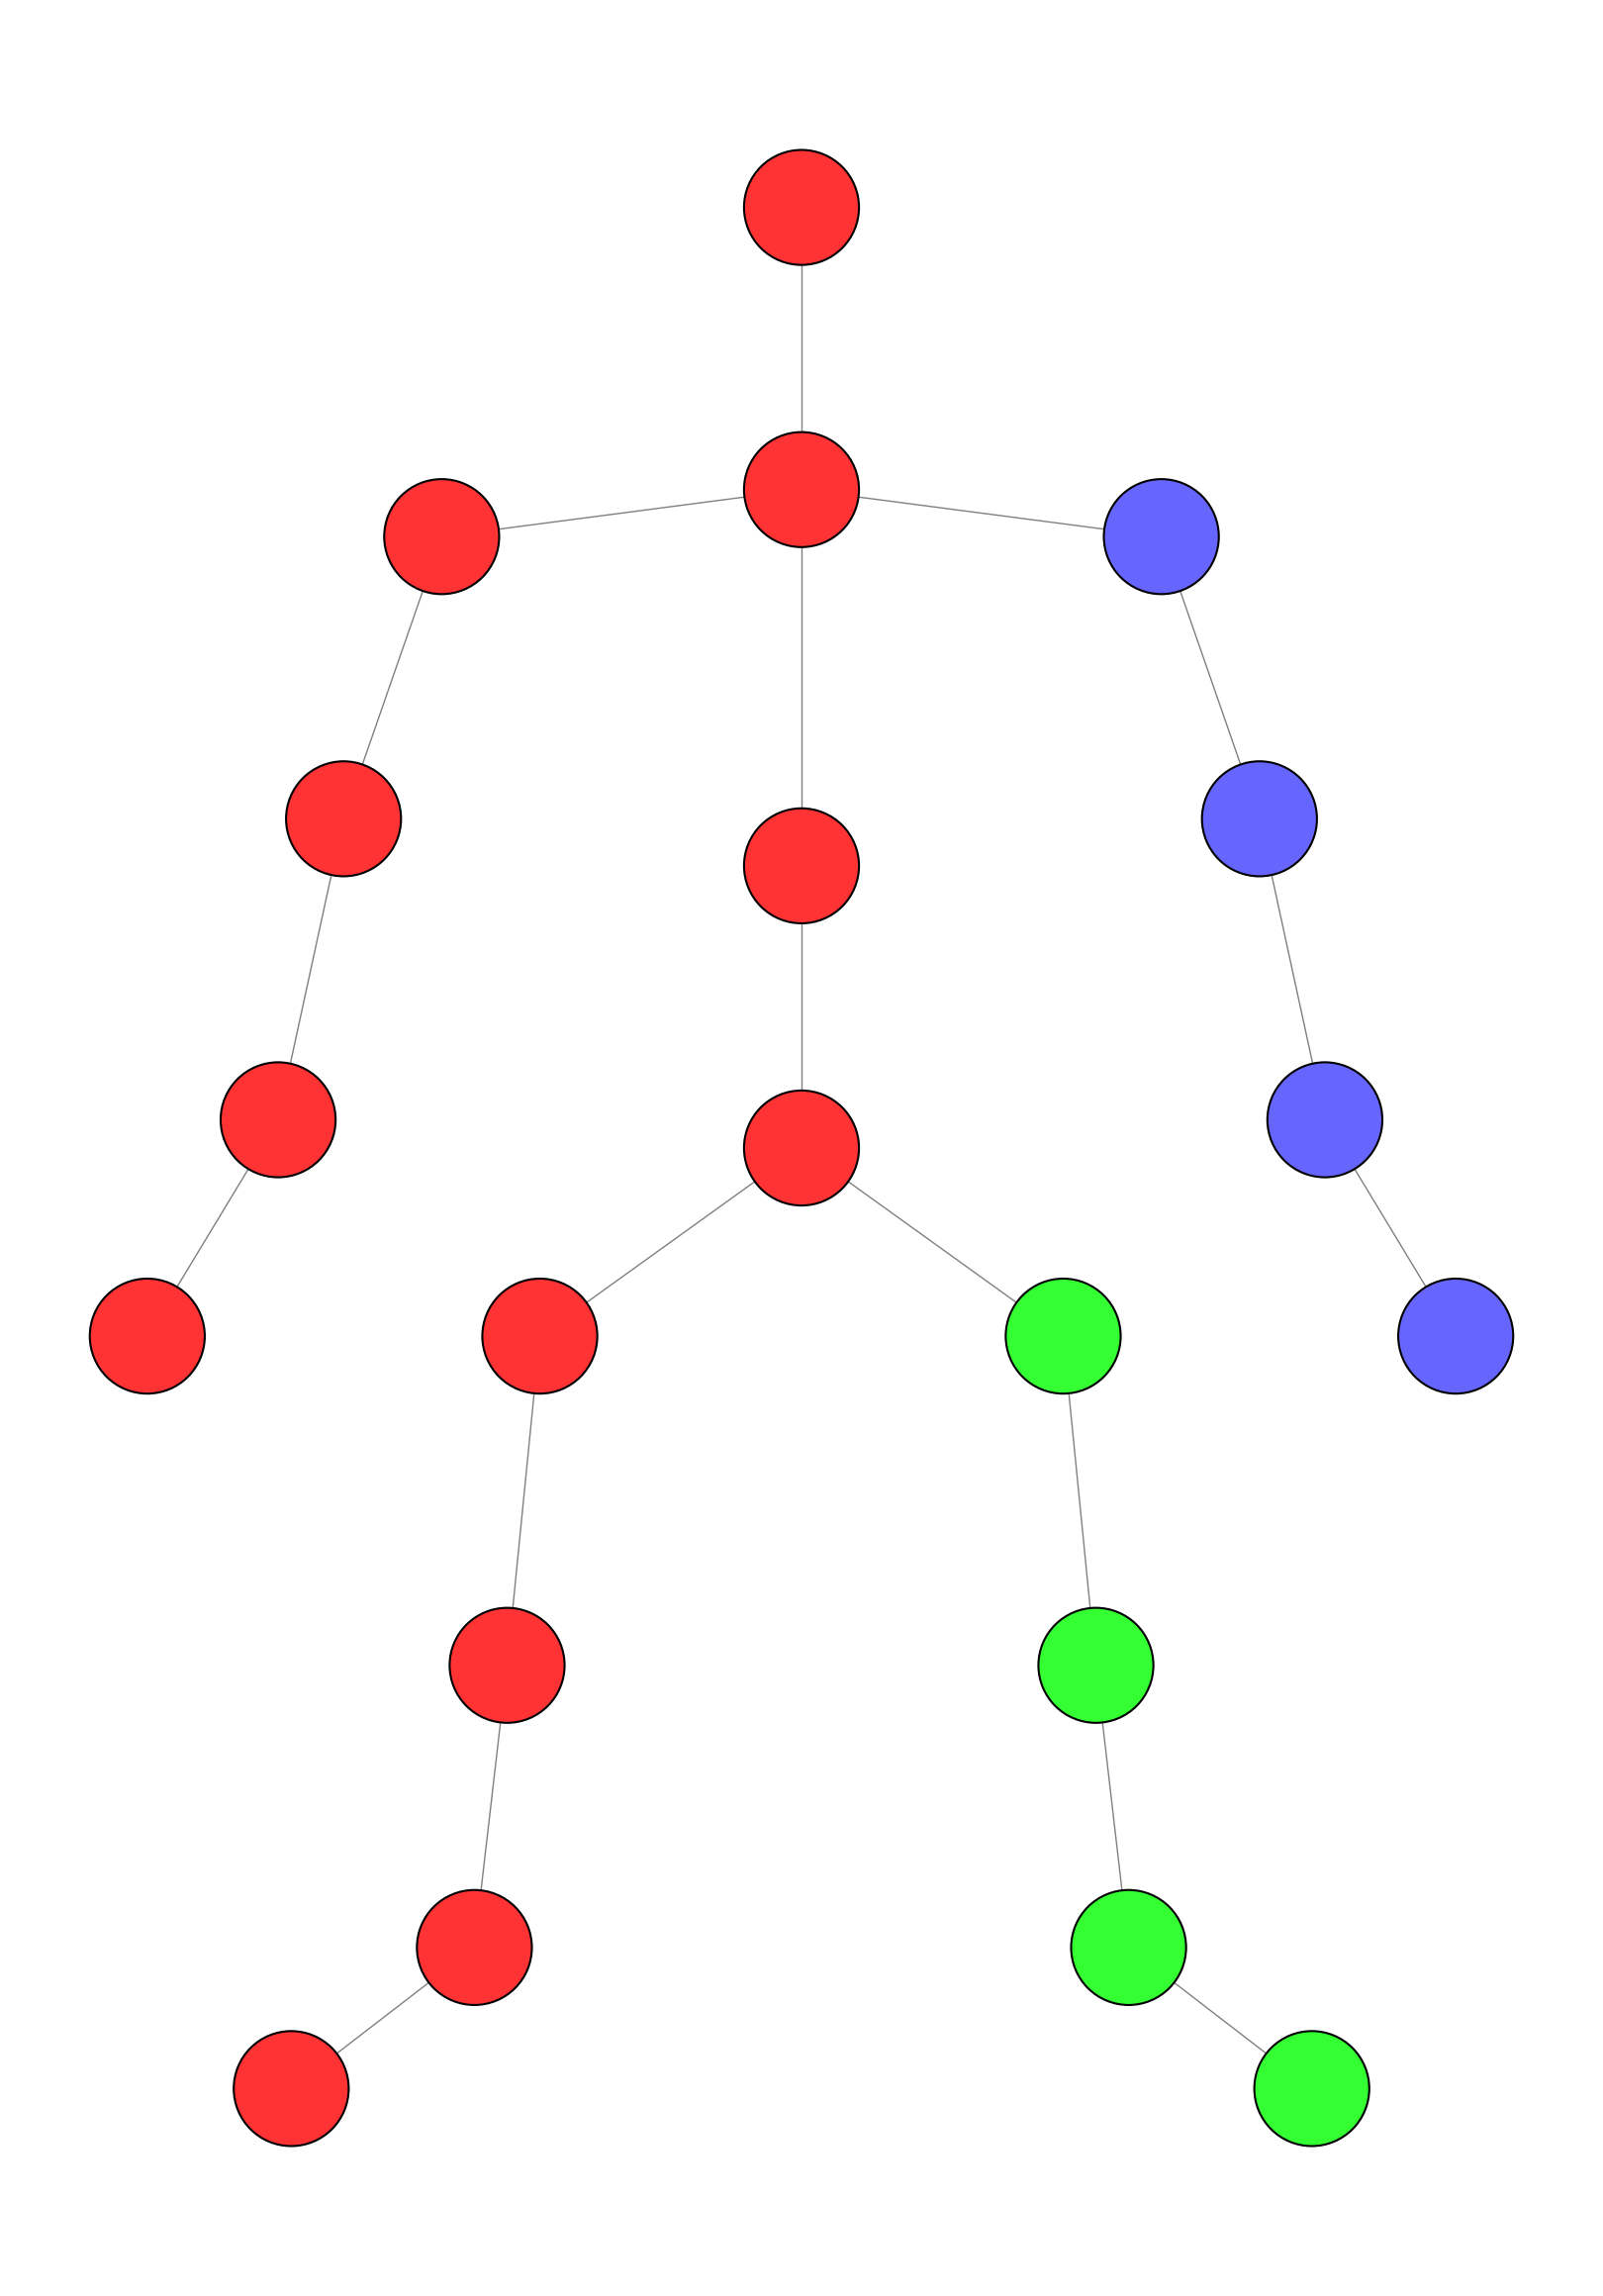

In [78]:
import networkx as nx
from clustering import *
%matplotlib inline

# Create a graph using NetworkX from the adjacency matrix
graph = nx.from_numpy_array(np.multiply(adjacencyMatrix,weightMatrix/2))


# Create a dictionary with the new labels for the nodes
labels = {node: str(round(featuresTable.iloc[timeInstant, i], 3)) for i, node in enumerate(graph.nodes())}

# Set the new labels as node attributes
nx.set_node_attributes(graph, labels, 'node_weight')

graph = nx.relabel_nodes(graph, {node: list(allNodes)[i] for i,node in enumerate(graph.nodes())})

# Get the new labels from the node attributes
labels = nx.get_node_attributes(graph, 'node_weight')

# Get edge labels from adjacency matrix (if present)
edge_labels = nx.get_edge_attributes(graph, "weight")
# Clip edge weights to the 2nd decimal place
for edge, weight in edge_labels.items():
    edge_labels[edge] = round(weight, 2)

pos = map_pos_human_body_graph()

color_pool = [(1,0.2,0.2),(0.2,1,0.2),(0.4,0.4,1)]

# Use the color pool to map cluster labels to colors
#predicted_labels_forced = [1]*10+[0,2,0,2,0,2,0,2,2,2] # BEFORE
predicted_labels_forced = [0,1,0,1,0,1,0,0,1,0,0,2,0,2,0,2,0,0,2,0] # GRAY
#color_pool = [(0.3,0.3,0.3),(0.6,0.6,0.6),(0.9,0.9,0.9)]
color_pool = [(1,0.2,0.2),(0.2,1,0.2),(0.4,0.4,1)]
node_colors = [color_pool[label % len(color_pool)] for label in predicted_labels_forced]

fig = plt.figure(figsize=figsize)
#canvas = fig.canvas
nx.draw(graph, 
        pos, 
        labels=labels, 
        with_labels=False, 
        node_size=7000, 
        node_color=node_colors, 
        edge_color="gray",
        font_size=25,
        node_shape="o",  # Set node shape to circular
        linewidths=1.5,  # Set the width of node border
        edgecolors='k')  # Set the node border color)#,font_weight='bold')
#nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=40, font_color='k', label_pos=0.5)
save_fig(fig,3)

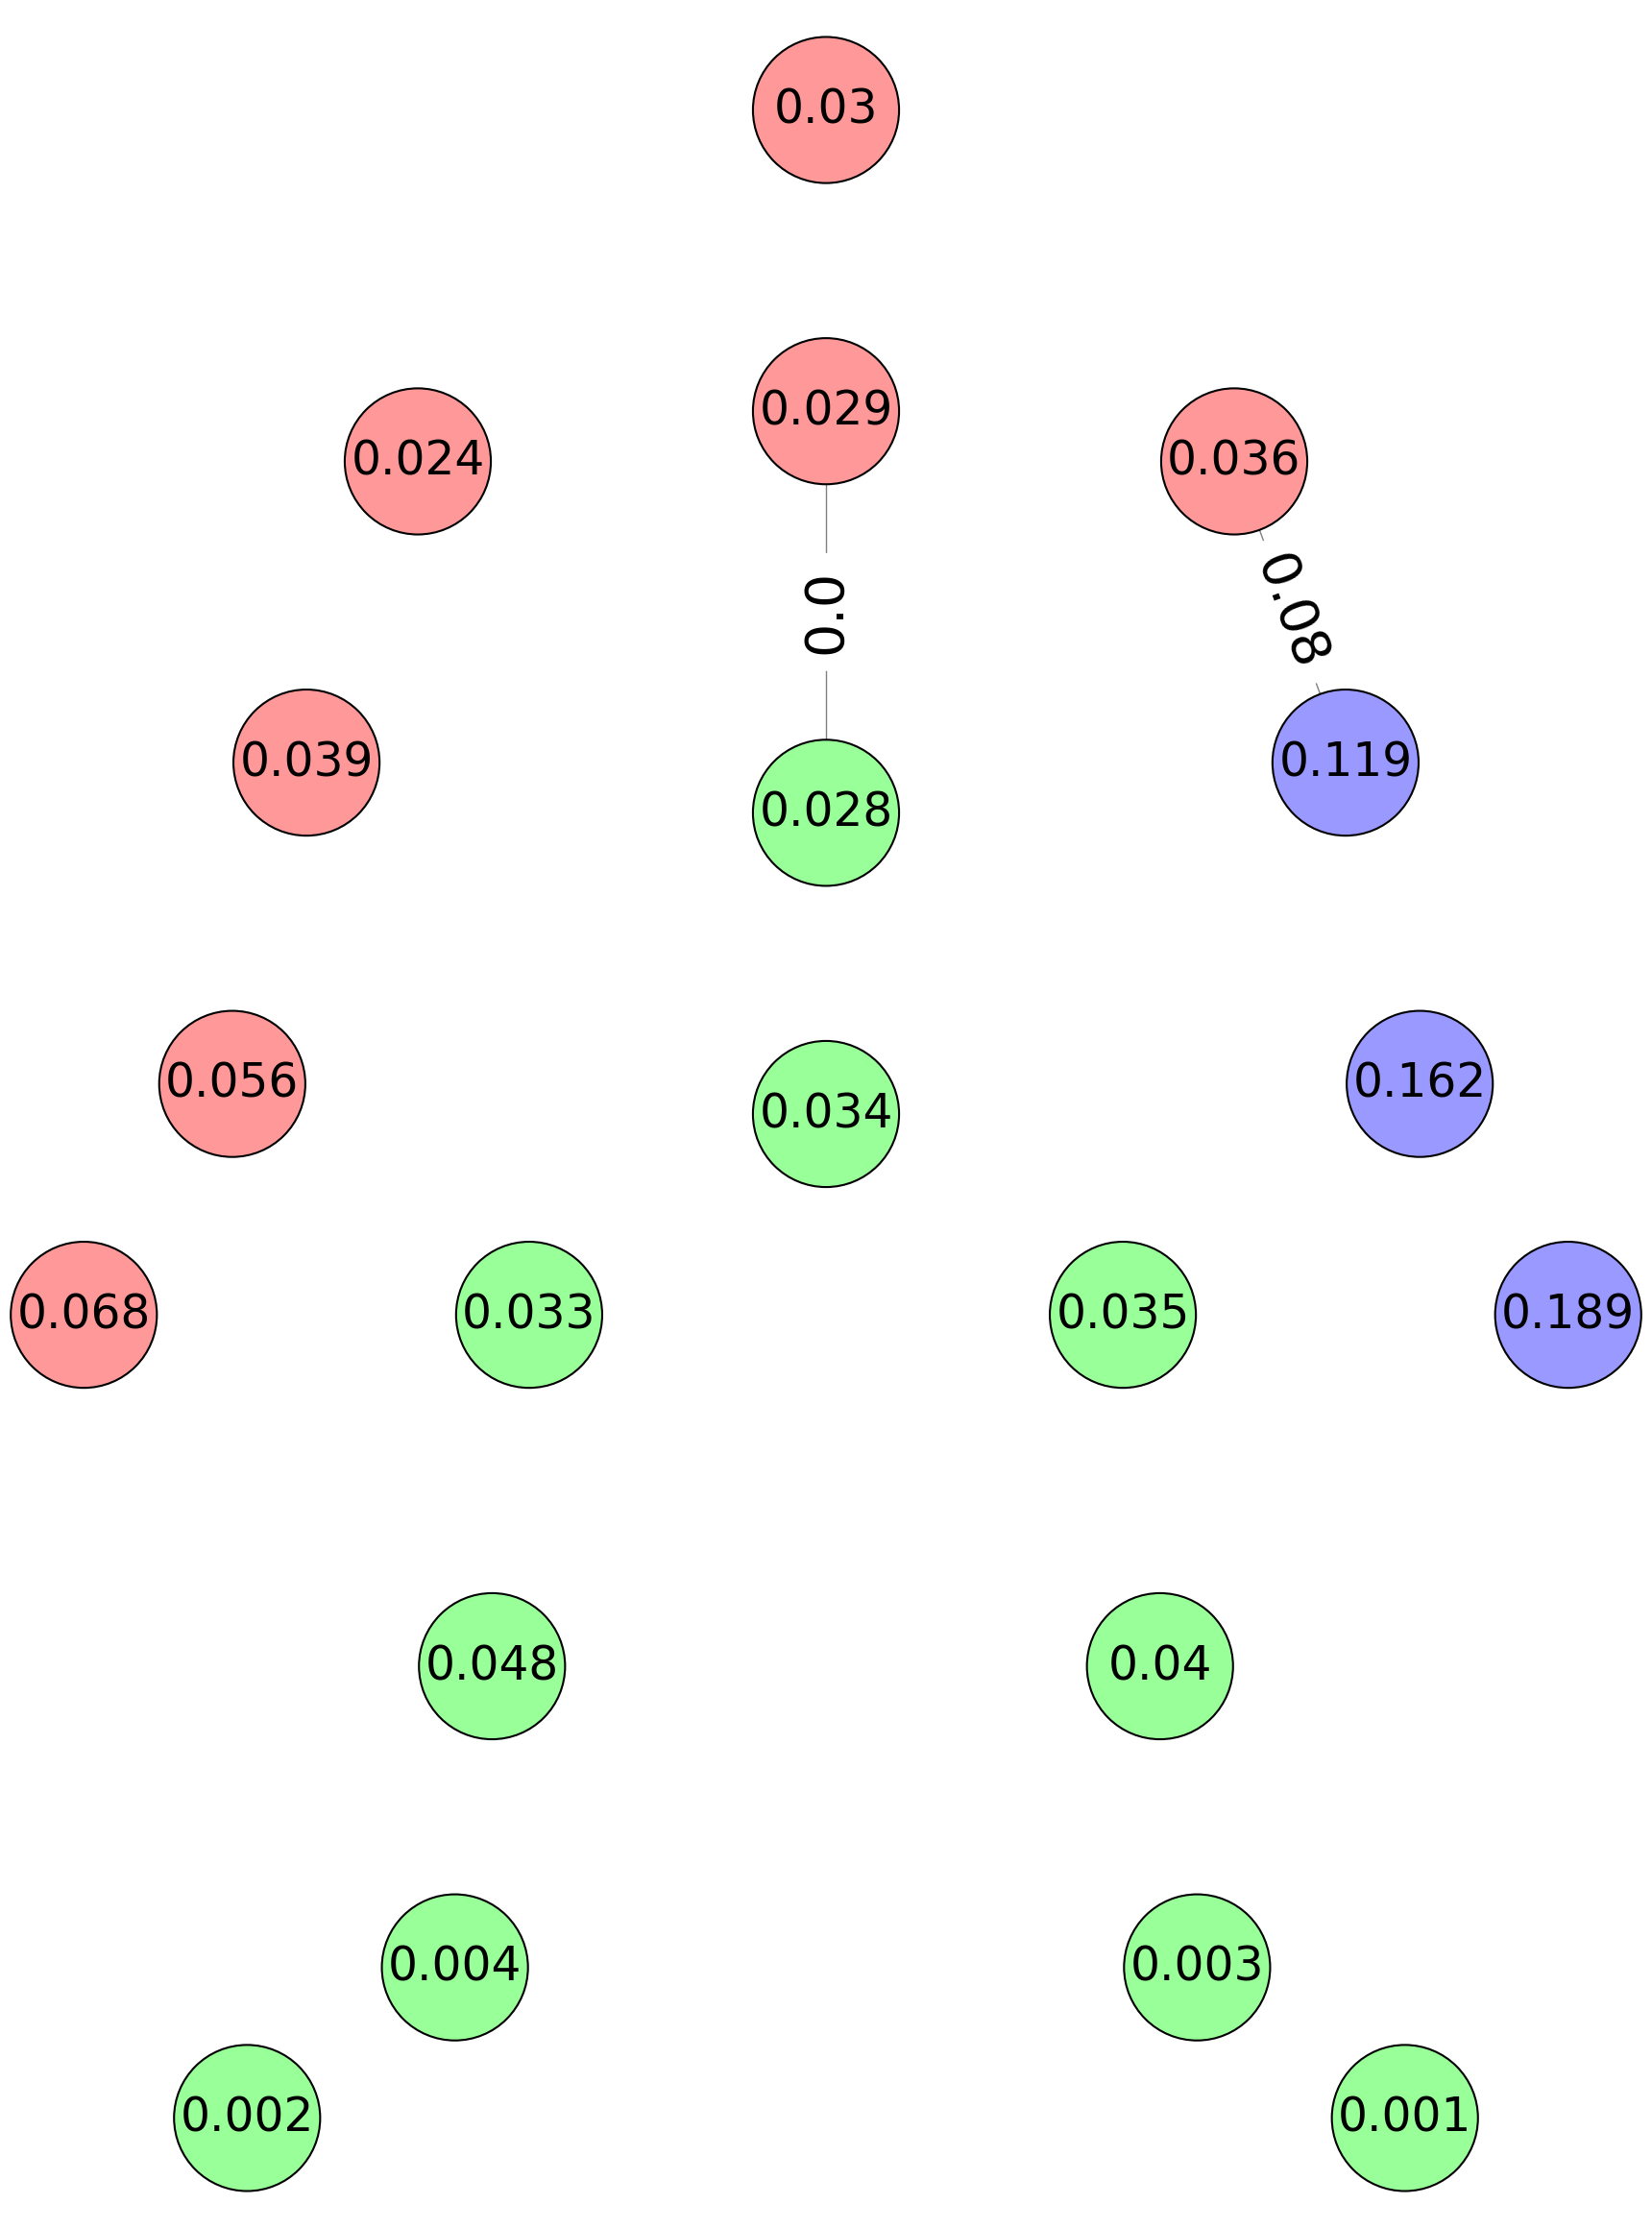

In [30]:
import networkx as nx
from clustering import *
%matplotlib inline

# Create a graph using NetworkX from the adjacency matrix
graph = nx.from_numpy_array(np.multiply(adjacencyMatrix,weightMatrixAux))


# Create a dictionary with the new labels for the nodes
labels = {node: str(round(featuresTable.iloc[timeInstant, i], 3)) for i, node in enumerate(graph.nodes())}

# Set the new labels as node attributes
nx.set_node_attributes(graph, labels, 'node_weight')

graph = nx.relabel_nodes(graph, {node: list(allNodes)[i] for i,node in enumerate(graph.nodes())})

# Get the new labels from the node attributes
labels = nx.get_node_attributes(graph, 'node_weight')

# Get edge labels from adjacency matrix (if present)
edge_labels = nx.get_edge_attributes(graph, "weight")
# Clip edge weights to the 2nd decimal place
for edge, weight in edge_labels.items():
    edge_labels[edge] = round(weight, 2)

pos = map_pos_human_body_graph()

color_pool = [(1,0.6,0.6),(0.6,1,0.6),(0.6,0.6,1)]

# Use the color pool to map cluster labels to colors
node_colors = [color_pool[label % len(color_pool)] for label in predicted_labels]

fig = plt.figure(figsize=(figsize[0]+1, figsize[1]))

nx.draw(graph, 
        pos, 
        labels=labels, 
        with_labels=True, 
        node_size=12000, 
        node_color=node_colors, 
        edge_color="gray",
        font_size=35,
        font_color='k',
        node_shape="o",  # Set node shape to circular
        linewidths=1.5,  # Set the width of node border
        edgecolors='k')  # Set the node border color)#,font_weight='bold')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=40, font_color='k', label_pos=0.5)
save_fig(fig,3)

In [ ]:
import networkx as nx
from clustering import *
%matplotlib

for timeInstant in range(-len(featuresTable)):
    plt.close('all')
    weightMatrix = calculate_weight_matrix(featuresTable.iloc[timeInstant],adjacencyMatrix,tol)
    predicted_labels = shi_malik_spectral_clustering_matlab_version(weightMatrix,3)
    weightMatrixAux = compute_auxiliary_graph(featuresTable.iloc[timeInstant],predicted_labels,adjacencyMatrix)

    # Create a graph using NetworkX from the adjacency matrix
    graph = nx.from_numpy_array(np.multiply(adjacencyMatrix,weightMatrixAux))


    # Create a dictionary with the new labels for the nodes
    labels = {node: str(round(featuresTable.iloc[timeInstant, i], 3)) for i, node in enumerate(graph.nodes())}

    # Set the new labels as node attributes
    nx.set_node_attributes(graph, labels, 'node_weight')

    graph = nx.relabel_nodes(graph, {node: list(allNodes)[i] for i,node in enumerate(graph.nodes())})

    # Get the new labels from the node attributes
    labels = nx.get_node_attributes(graph, 'node_weight')

    # Get edge labels from adjacency matrix (if present)
    edge_labels = nx.get_edge_attributes(graph, "weight")
    # Clip edge weights to the 2nd decimal place
    for edge, weight in edge_labels.items():
        edge_labels[edge] = round(weight, 2)

    pos = map_pos_human_body_graph()

    color_pool = [(1,0.2,0.2),(0.2,1,0.2),(0.4,0.4,1)]

    # Use the color pool to map cluster labels to colors
    node_colors = [color_pool[label % len(color_pool)] for label in predicted_labels]

    fig = plt.figure(figsize=figsize)
    #canvas = fig.canvas
    nx.draw(graph, 
            pos, 
            labels=labels, 
            with_labels=False, 
            node_size=7000, 
            node_color=node_colors, 
            edge_color="gray",
            font_size=25,
            node_shape="o",  # Set node shape to circular
            linewidths=1.5,  # Set the width of node border
            edgecolors='k')  # Set the node border color)#,font_weight='bold')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=30, font_color='k', label_pos=0.5)
    save_fig(fig,timeInstant)
    print(f'Progress: {timeInstant}/{len(featuresTable)}   ',end='\r')
plt.close('all')
print()

Using matplotlib backend: <object object at 0x7f7da16d17c0>



In [ ]:
from clustering import *
from matplotlib import pyplot as plt
%matplotlib

nodes = ['right_foot',
         'left_foot',
         'right_ank',
         'left_ank',
         'right_knee',
         'left_knee',
         'right_hip',
         'hip_center',
         'left_hip',
         'spine',
         'right_hand',
         'left_hand',
         'right_wrist',
         'left_wrist',
         'right_elbow',
         'left_elbow',
         'right_shoulder',
         'shoulder_center',
         'left_shoulder',
         'head']

max_shapleys = [0]*20
second_max_shapleys = [0]*20
blue_color = (68/255,114/255,196/255)

fig = plt.figure(figsize=(21,16))
from matplotlib.ticker import MaxNLocator
from collections import Counter

best_shapleys = [0]*20

for timeInstant in range(-len(featuresTable)):
    plt.bar(range(20), best_shapleys, color=blue_color)
    plt.ylabel('Frequency', fontsize=22)
    plt.xlabel("Joint", fontsize=22)
    plt.xticks(range(20), nodes, rotation=45, ha='right', fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(axis='y')
    plt.tight_layout()
    ax = fig.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_axisbelow(True)
    save_fig(fig,"_graph_"+str(timeInstant), crop=False)
    fig.clear()
    weightMatrix = calculate_weight_matrix(featuresTable.iloc[timeInstant],adjacencyMatrix,tol)
    predicted_labels = shi_malik_spectral_clustering_matlab_version(weightMatrix,3)
    weightMatrix = compute_auxiliary_graph(featuresTable.iloc[timeInstant],predicted_labels,adjacencyMatrix)
    best_shapleys[np.argmax(calculate_shapley_values(weightMatrix)[0])] += 1
    weightMatrix_copy = weightMatrix.copy()
    weightMatrix_copy[np.unravel_index(np.argmax(weightMatrix_copy), weightMatrix_copy.shape)] = -1.
    best_shapleys[np.argmax(calculate_shapley_values(weightMatrix)[0])] += 1
    #if timeInstant == len(posTable)-1:
    #    top_two_shapleys = list(zip(*list(sorted(Counter(best_shapleys).items(), key=lambda x: x[1], reverse=True))[:2]))[0]
    
    print(f"Progress: {timeInstant+1} / {len(featuresTable)}  ",end='\r')
    
plt.bar(range(20), best_shapleys, color=blue_color)
plt.ylabel('Frequency', fontsize=22)
plt.xlabel("Joint", fontsize=22)
plt.xticks(range(20), nodes, rotation=45, ha='right', fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='y')
plt.tight_layout()
ax = fig.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_axisbelow(True)
save_fig(fig,"_graph_"+str(len(featuresTable)-1), crop=False)
fig.clear() 
plt.close('all')
print()

Using matplotlib backend: TkAgg



In [ ]:
# 1500 x 2100
# 2100 x 1600
import cv2 
from PIL import Image
import os

in_video = cv2.VideoCapture('_trial.mp4') # 50 fps

#print(in_video.get(cv2.CAP_PROP_FRAME_WIDTH),in_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
for i in range(-int(in_video.get(cv2.CAP_PROP_FPS)*36.3)):
    in_video.read()

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

plt.imshow(in_video.read()[1][:,350:750])

#print(in_video.read()[1][:,350:750].shape) # 400 x 720

out = cv2.VideoWriter('_WDC.mp4', 
                      cv2.VideoWriter_fourcc(*'mp4v'), 
                      8,
                      (4800,2100))  # Adjust the filename, codec, frame rate, and frame size

filler = np.zeros((250,2100,3),dtype=np.uint8)+255

found_face = None
blurr = None
tic = 15

for i in range(-len(featuresTable)):
    wdc_frame = cv2.cvtColor(cv2.resize(np.array(Image.open(os.path.join('_wdc','_cropped_fig'+str(i)+'.png'))),(1500,2100)), cv2.COLOR_RGB2BGR)
    graph_frame = cv2.cvtColor(np.array(Image.open(os.path.join('_wdc','_cropped_fig_graph_'+str(i)+'.png'))), cv2.COLOR_RGB2BGR)

    frame = cv2.resize(in_video.read()[1][:,350:750],(1200,2100))
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)[600:950,300:900]
    #plt.imshow(gray_frame); raise Exception()
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.05, minNeighbors=5)

    if len(faces) == 0 and found_face is not None and tic > 0:
        frame[found_face[1]:found_face[1]+found_face[3],found_face[0]:found_face[0]+found_face[2]] = blurr
    for (x, y, w, h) in faces:
        # Apply blur to the detected face region
        blurred_face = cv2.GaussianBlur(frame[600+y:600+y+h, -100+300+x:300+x+w], (99, 99), 30)
        frame[600+y:600+y+h, -100+300+x:300+x+w] = blurred_face
        found_face = (-100+300+x,600+y,w+100,h)
        blurr = blurred_face
        tic = 50
    tic -= 1
    print(i,'/',len(featuresTable),end='\r')
    out.write(np.hstack((frame,wdc_frame,np.vstack((filler,graph_frame,filler)))))

out.release()

In [ ]:
raise Exception()

import networkx as nx
from clustering import *
%matplotlib inline

# Create a graph using NetworkX from the adjacency matrix
graph = nx.from_numpy_array(np.multiply(adjacencyMatrix,weightMatrix))
graph = nx.relabel_nodes(graph, {node: list(allNodes)[i] for i,node in enumerate(graph.nodes())})

# Get edge labels from adjacency matrix (if present)
edge_labels = nx.get_edge_attributes(graph, "weight")
# Clip edge weights to the 2nd decimal place
for edge, weight in edge_labels.items():
    edge_labels[edge] = round(weight, 2)

# You can also create an undirected graph by using create_using=nx.Graph

pos = map_pos_human_body_graph()
# Create the colormap
# Define a pool of colors for k classes (you can add more colors if needed)
color_pool = ['#e31a1c', '#1f78b4', '#33a02c', '#ff7f00', '#6a3d9a', '#b15928']
#color_pool = ['#ff7777','#77ff77','#7777ff']

# Use the color pool to map cluster labels to colors
node_colors = [color_pool[label % len(color_pool)] for label in predicted_labels]

fig = plt.figure(figsize=(9,13))
#canvas = fig.canvas
nx.draw(graph, pos, with_labels=True, node_size=1000, node_color=node_colors, edge_color="gray",font_size=18,font_weight='bold')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=20, font_color='gray', label_pos=0.5)

plt.show()

Exception: 

## Video face censoring
TODO improve

In [ ]:
import cv2
import numpy as np
from tqdm.notebook import tqdm
import os

# Load a pre-trained face detection model (e.g., Haar Cascade)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
half_body_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_upperbody.xml')


video_path = '/'.join(os.getcwd().split('/')[:-2]+['docs','presentation','resources','_'.join([folder,trial])+'.mp4'])

vidcap = cv2.VideoCapture(video_path[:-4]+'_'+str(100)+'fps.mp4')

# Get video details
fps = int(vidcap.get(cv2.CAP_PROP_FPS))
width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

# Define a function to censor faces
def censor_faces(frame,i):
    if i < 5800:
        frame_crop = frame[height//4:height//4+int(height/2.5),int(width/7.5):int(width/7.5)+int(width/2.1)]
        gray = cv2.cvtColor(frame_crop, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray,scaleFactor=1.1, minNeighbors=5, minSize=(15, 15), maxSize=(40,40))
    else:
        frame_crop = frame[height//3:height//3+int(height/6),int(width/1.9):int(width/1.9)+int(width/6)]
        gray = cv2.cvtColor(frame_crop, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.03, minNeighbors=1, minSize=(30, 30), maxSize=(40,40))
    if not any(static_face_censor_delay) and len(faces) == 0:
        gray = cv2.addWeighted(gray, 3.1, np.zeros_like(gray), 0, 0)
        half_body = half_body_cascade.detectMultiScale(gray, scaleFactor=1.01, minNeighbors=5, minSize=(120, 120), maxSize=(200,200))
        return *apply_censoring(frame,half_body,is_body=True), half_body
    return *apply_censoring(frame,faces,i=i), faces

def apply_censoring(frame, bb, i=-1, is_body=False):
    for (x, y, w, h) in bb:
        # Apply censorship here, e.g., pixelation
        if is_body:
            x += int(width/7.5) + 30 ; y += height//4 + 40
            w = 60; h = 50
        else:
            if i < 5800:
                enlarger = 4
                x += int(width/7.5) - enlarger; y += height//4 - enlarger
                w += 4*enlarger; h += 4*enlarger
            else:
                enlarger = 10
                x += int(width/1.9)-enlarger ; y += height//3-enlarger
                w += 2*enlarger; h += 2*enlarger
        roi = frame[y:y+h,x:x+w]
        roi = cv2.GaussianBlur(roi, (23, 23), 9)
        frame[y:y+h, x:x+w] = roi
    return frame, is_body

static_face_window = 400
static_face_censor_delay = np.zeros(static_face_window, bool)
moving_face_window = 300
moving_face_censor_delay = np.zeros(moving_face_window, bool)

last_faces = None

if not os.path.isfile(video_path[:-4]+'_face_censored.mp4') and False:
    # Create an output video writer
    out = cv2.VideoWriter(video_path[:-4]+'_face_censored.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    _, frame = vidcap.read()
    faces = [[477, 75, 30, 30]]
    frame,_ = apply_censoring(frame, faces)
    censored = True
    is_body = False
    for i in tqdm(range(1,num_frames), 'Blurring face',miniters=20):
        if is_body:
            moving_face_censor_delay[i%moving_face_window] = censored
            static_face_censor_delay[i%static_face_window] = False
        else:
            static_face_censor_delay[i%static_face_window] = censored
            moving_face_censor_delay[i%moving_face_window] = False

        if censored:
            last_faces = faces
        if not censored and ((not is_body and any(static_face_censor_delay)) or (is_body and any(moving_face_censor_delay))):
            frame,_ = apply_censoring(frame, last_faces, is_body=is_body)
        #frame = cv2.rectangle(frame, (int(width/7.5), height//4), (int(width/7.5) + int(width/2.1), height//4 + int(height/2.5)), (255, 0, 0), 2)
        # Add the text to the image
        #frame = cv2.putText(frame, str(i), (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        # Write the frame to the output video
        out.write(frame)

        _, frame = vidcap.read()
        
        # Apply censorship to the frame
        frame, is_body, faces = censor_faces(frame,i)
        censored = len(faces) > 0

    out.release()
vidcap.release()


AttributeError: module 'cv2' has no attribute 'data'

In [ ]:
import xml.etree.ElementTree as ET

# Replace 'your_file.xml' with the actual XML file you want to read
xml_file = ANNOTATIONS_PATH+'/labels.xml'
#xml_file = ANNOTATIONS_PATH+'/41LabelsDuo.xml'
xml_file = ANNOTATIONS_PATH+'/64markersLabel.xml'


# Parse the XML file
root = ET.parse(xml_file).getroot()

bones_unsorted = []
max_indx = 0
# Explore the "Bone" elements
for bone in root.findall(".//Bone"):
    #print("Bone:")
    for index in bone.findall(".//Index"):
        low = index.get("Low")
        high = index.get("High")
        #print(f"  Index: Low={low}, High={high}")
        bones_unsorted.append((int(low)-1,int(high)-1))
        if int(low) > max_indx or int(high) > max_indx:
            max_indx = max(int(low),int(high))

markers = []
# Explore the "Trajectory" elements
for trajectory in root.findall(".//Trajectory"):
    name = trajectory.find(".//Name").text
    #print(f"Trajectory: Name={name}")
    markers.append(name)

markersMap = {markers.index(marker):marker for marker in markers}

In [ ]:
fullPosTableX = 1-fullMarkersTable.iloc[:,3::3]
fullPosTableZ = fullMarkersTable.iloc[:,4::3]
fullPosTableY = fullMarkersTable.iloc[:,5::3]

fullPosTableX = fullPosTableX.reindex(columns=sorted(fullPosTableX.columns))
fullPosTableY = fullPosTableY.reindex(columns=sorted(fullPosTableY.columns))
fullPosTableZ = fullPosTableZ.reindex(columns=sorted(fullPosTableZ.columns))

column_names = [col[:-2] for col in fullPosTableX.columns]
bones = [sorted((column_names.index(markersMap[fromJoint]),column_names.index(markersMap[toJoint]))) for fromJoint,toJoint in bones_unsorted if markersMap[fromJoint] in column_names and markersMap[toJoint] in column_names]

fullPosTableX = fullPosTableX.rename(columns=dict(zip(list(fullPosTableX),[name.replace('Z','X').replace('Y','X') for name in list(fullPosTableX)])))
fullPosTableY = fullPosTableY.rename(columns=dict(zip(list(fullPosTableY),[name.replace('Z','Y').replace('X','Y') for name in list(fullPosTableY)])))
fullPosTableZ = fullPosTableZ.rename(columns=dict(zip(list(fullPosTableZ),[name.replace('X','Z').replace('Y','Z') for name in list(fullPosTableZ)])))

## Preview of the stage of Full Markerset

In [ ]:
from matplotlib import pyplot as plt
%matplotlib
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


edges = np.array(bones)
adjacencyMatrix = np.zeros((len(list(fullPosTableX.columns)),len(list(fullPosTableX.columns))),dtype=bool)
adjacencyMatrix[edges[:,0],edges[:,1]] = True

plt.close("all")
fig = plt.figure(figsize=(960/100, 720/100), dpi=100)

# Add a 3D subplot with the specified position and size
ax = fig.add_axes([-0.05, -0.4, 1, 1.7], projection='3d')
ax.view_init(elev=10, azim=-90.6)


minMax = np.zeros((2,3))
minMax[0,:] = [fullPosTableX.values.min(),fullPosTableY.values.min(),fullPosTableZ.values.min()]
minMax[1,:] = [fullPosTableX.values.max(),fullPosTableY.values.max(),fullPosTableZ.values.max()]

# Set appropriate axis limits
ax.set_xlim([minMax[0,0],minMax[1,0]])
ax.set_ylim([minMax[0,1],minMax[1,1]])
ax.set_zlim([minMax[0,2],minMax[1,2]])

# Set the window title
fig.canvas.manager.window.title("3D Movement\t(Scroll with mouse wheel)")


colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'cyan']
plt.rcParams['grid.color'] = 'white'
ax.tick_params(axis='both', colors='w')
# Remove box faces except the ground
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = True
ax.w_zaxis.pane.set_facecolor((0.92,.92,.92))
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor((0,0,0))
# Hide axis spines and ticks
ax.w_xaxis.line.set_visible(False)
ax.w_yaxis.line.set_visible(True)
ax.w_zaxis.line.set_visible(False) 

def update_plot(val):
    #ax.cla()  # Clear the previous plot

    # Filter the data based on the current time index
    filteredX = fullPosTableX.iloc[val]
    filteredY = fullPosTableY.iloc[val]
    filteredZ = fullPosTableZ.iloc[val]
    
    # Update scatter plot data instead of creating a new scatter plot
    scatter_plot = ax.collections[0]
    scatter_plot.set_offsets(np.column_stack((filteredX, filteredY)))
    scatter_plot._offsets3d = (filteredX, filteredY, filteredZ)

    # Update edges based on the weight matrix
    #print(len(adjacencyMatrix))
    k = 0
    for i in range(len(adjacencyMatrix)):
        for j in range(0, len(adjacencyMatrix)):
            if adjacencyMatrix[i, j]:
                # Find the existing line corresponding to this edge and update its coordinates
                #print(ax.lines[1])
                line = allLines[k]#ax.lines[i * len(adjacencyMatrix) + j]
                line.set_xdata([filteredX[i], filteredX[j]])
                line.set_ydata([filteredY[i], filteredY[j]])
                line.set_3d_properties([filteredZ[i], filteredZ[j]])
                k+=1

    #ax.set_xlim([0, 1])
    #ax.set_ylim([fullMinMax[0, 1], fullMinMax[1, 1]])
    #ax.set_zlim([fullMinMax[0, 2], fullMinMax[1, 2]])

    #ax.set_xticks([])
    #ax.set_yticks([])
    #ax.set_zticks([])

    fig.canvas.draw_idle()
    #buf = fig.canvas.tostring_rgb()
    #ncols, nrows = fig.canvas.get_width_height()
    #frame = np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

    #return frame

filteredX = fullPosTableX.iloc[0]
filteredY = fullPosTableY.iloc[0]
filteredZ = fullPosTableZ.iloc[0]

allLines = []

ax.scatter(fullPosTableX.iloc[0],fullPosTableY.iloc[0],fullPosTableZ.iloc[0], s=10)
for i in range(len(adjacencyMatrix)):
    for j in range(len(adjacencyMatrix)):
        if adjacencyMatrix[i,j]:
            ax.plot([filteredX[i], filteredX[j]],
                    [filteredY[i], filteredY[j]],
                    [filteredZ[i], filteredZ[j]],
                    color='k', linestyle='-', linewidth=0.7)
            allLines.append(ax.lines[-1])


# Function to update the plot based on the slider value
def update_plot2(val):
    ax.cla()  # Clear the previous plot
    
    # Filter the data based on the current time index
    filteredX = fullPosTableX.iloc[val]
    filteredY = fullPosTableY.iloc[val]
    filteredZ = fullPosTableZ.iloc[val]
    
    ax.scatter(filteredX,filteredY,filteredZ,s=10)

    # Add edges based on the weight matrix
    for i in range(len(adjacencyMatrix)):
        for j in range(len(adjacencyMatrix)):
            if adjacencyMatrix[i,j]:
                ax.plot([filteredX[i], filteredX[j]],
                        [filteredY[i], filteredY[j]],
                        [filteredZ[i], filteredZ[j]],
                        color='k', linestyle='-', linewidth=0.7)

    ax.set_xlim([0,1])#minMax[0,0],minMax[1,0]])
    ax.set_ylim([0,1])
    ax.set_zlim([minMax[0,2],minMax[1,2]])
    
    #ax.set_xlabel('X', fontsize=12)
    #ax.set_ylabel('Y', fontsize=12)

    #ax.set_zlabel('Z', fontsize=12)
    #ax.set_title("Movement "+str(picked))
    #ax.grid(axis=['x','y'])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    #ax.set_zticklabels([])
    fig.canvas.draw_idle()
    
# Create a slider widget
slider_ax = plt.axes([0.2, 0.03, 0.6, 0.03])
maxValue = fullPosTableX.shape[0]-1
slider = Slider(slider_ax, 'TimeIndex:', 0, maxValue, valinit=0, valstep=1)


# Define a function to update the slider value with the mouse wheel
def on_scroll(event):
    if event.button == 'down':
        if slider.val + slider.valstep <= maxValue:
            slider.set_val(slider.val + slider.valstep)
    elif event.button == 'up':
        if slider.val - slider.valstep >= 0:
            slider.set_val(slider.val - slider.valstep)
        

# Connect the mouse wheel event to the function
fig.canvas.mpl_connect('scroll_event', on_scroll)


# Register the update_plot function with the slider widget
slider.on_changed(update_plot)

# Initial plot
update_plot(0)

# Show the plot
plt.show()


Using matplotlib backend: TkAgg


/tmp/ipykernel_45440/508400176.py:37: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.pane.fill = False
/tmp/ipykernel_45440/508400176.py:38: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.pane.fill = False
/tmp/ipykernel_45440/508400176.py:39: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.pane.fill = True
/tmp/ipykernel_45440/508400176.py:40: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.pane.set_facecolor((0.92,.92,.92))
/tmp/ipykernel_45440/508400176.py:45: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xax

In [ ]:
import cv2
import os

# Open the video file
video_path = '/'.join(os.getcwd().split('/')[:-2]+['docs','presentation','resources','_'.join([folder,trial])+'.mp4'])
print(video_path)
cap = cv2.VideoCapture(video_path)

# Get the frames per second (FPS)
fps = int(cap.get(cv2.CAP_PROP_FPS))
print(fps, cap.get(cv2.CAP_PROP_FRAME_COUNT))
ret, prev_frame = cap.read()
ret= not os.path.isfile(video_path[:-4]+'_'+str(fps * 2)+'fps.mp4') and False
num_frames = 0
if ret:
    output = cv2.VideoWriter(video_path[:-4]+'_'+str(fps * 2)+'fps.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps * 2, (int(cap.get(3)), int(cap.get(4))))
    while True:
        if num_frames < len(fullMarkersTable):
            output.write(prev_frame)
            num_frames += 1
        ret, frame = cap.read()
        if not ret:
            break
        averaged_frame = cv2.addWeighted(prev_frame, 0.5, frame, 0.5, 0)
        if num_frames < len(fullMarkersTable):
            output.write(averaged_frame)
            num_frames += 1
        else: break
        prev_frame = frame
    output.release()
else: 
    vidcap = cv2.VideoCapture(video_path[:-4]+'_'+str(fps * 2)+'fps_540p.mp4')
    print(vidcap.get(cv2.CAP_PROP_FRAME_COUNT), vidcap.get(3),vidcap.get(4))
print(num_frames)

# Release the video file
cap.release()


/home/gagg/Desktop/Thesis/OoM-Thesis/docs/presentation/resources/2020-07-08_t_052.mp4
0 0.0
0.0 0.0 0.0
0


## Setting stage for full Markerset

In [ ]:
from matplotlib import pyplot as plt
%matplotlib

edges = np.array(bones)
fullAdjacencyMatrix = np.zeros((len(fullPosTableX.iloc[0]),len(fullPosTableX.iloc[0])),dtype=bool)
fullAdjacencyMatrix[edges[:,0],edges[:,1]] = True

plt.close("all")
#fig_full = plt.figure(figsize=(960/100, 540/100), dpi=100)
fig_full = plt.figure(figsize=(1920/100, 1080/100), dpi=100)

# Add a 3D subplot with the specified position and size
ax_full = fig_full.add_axes([-0.3, -0.3, 1.6, 1.6], projection='3d')
ax_full.view_init(elev=10, azim=-90.6)


fullMinMax = np.zeros((2,3))
fullMinMax[0,:] = [fullPosTableX.values.min(),fullPosTableY.values.min(),fullPosTableZ.values.min()]
fullMinMax[1,:] = [fullPosTableX.values.max(),fullPosTableY.values.max(),fullPosTableZ.values.max()]

# Set appropriate axis limits
ax_full.set_xlim([fullMinMax[0,0],fullMinMax[1,0]])
ax_full.set_ylim([fullMinMax[0,1],fullMinMax[1,1]])
ax_full.set_zlim([fullMinMax[0,2],fullMinMax[1,2]])


plt.rcParams['grid.color'] = 'white'
ax_full.tick_params(axis='both', colors='w')
# Remove box faces except the ground
ax_full.w_xaxis.pane.fill = False
ax_full.w_yaxis.pane.fill = False
ax_full.w_zaxis.pane.fill = True
ax_full.w_zaxis.pane.set_facecolor((0.92,.92,.92))
ax_full.xaxis.pane.set_edgecolor('w')
ax_full.yaxis.pane.set_edgecolor('w')
ax_full.zaxis.pane.set_edgecolor((0,0,0))
# Hide axis spines and ticks
ax_full.w_xaxis.line.set_visible(False)
ax_full.w_yaxis.line.set_visible(True)
ax_full.w_zaxis.line.set_visible(False) 


filteredX = fullPosTableX.iloc[0]
filteredY = fullPosTableY.iloc[0]
filteredZ = fullPosTableZ.iloc[0]

allLines = []

ax_full.scatter(fullPosTableX.iloc[0],fullPosTableY.iloc[0],fullPosTableZ.iloc[0], s=10)
for i in range(len(fullAdjacencyMatrix)):
    for j in range(len(fullAdjacencyMatrix)):
        if fullAdjacencyMatrix[i,j]:
            ax_full.plot([filteredX[i], filteredX[j]],
                    [filteredY[i], filteredY[j]],
                    [filteredZ[i], filteredZ[j]],
                    color='k', linestyle='-', linewidth=0.7)
            allLines.append(ax_full.lines[-1])

Using matplotlib backend: TkAgg


/tmp/ipykernel_45440/3546282892.py:30: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax_full.w_xaxis.pane.fill = False
/tmp/ipykernel_45440/3546282892.py:31: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax_full.w_yaxis.pane.fill = False
/tmp/ipykernel_45440/3546282892.py:32: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax_full.w_zaxis.pane.fill = True
/tmp/ipykernel_45440/3546282892.py:33: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax_full.w_zaxis.pane.set_facecolor((0.92,.92,.92))
/tmp/ipykernel_45440/3546282892.py:38: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use 

In [ ]:
reducedPosTableX = reducedMarkersTable.iloc[:,::3]
reducedPosTableZ = reducedMarkersTable.iloc[:,1::3]
reducedPosTableY = 1-reducedMarkersTable.iloc[:,2::3]

reducedPosTableX = reducedPosTableX.rename(columns=dict(zip(list(reducedPosTableX),[name.replace('Z','X').replace('Y','X') for name in list(reducedPosTableX)])))
reducedPosTableY = reducedPosTableY.rename(columns=dict(zip(list(reducedPosTableY),[name.replace('Z','Y').replace('X','Y') for name in list(reducedPosTableY)])))
reducedPosTableZ = reducedPosTableZ.rename(columns=dict(zip(list(reducedPosTableZ),[name.replace('X','Z').replace('Y','Z') for name in list(reducedPosTableZ)])))

jointsFrom = [1, 3, 5, 7, 2, 4, 6, 9, 8,10,11,13,15,17,12,14,16,19,18]
jointsTo =   [3, 5, 7, 8, 4, 6, 9, 8,10,18,13,15,17,18,14,16,19,18,20]
jointsFrom = list(map(lambda x: x-1,jointsFrom))
jointsTo = list(map(lambda x: x-1,jointsTo))
edges = np.array(list(zip(jointsFrom,jointsTo))+list(zip(jointsTo,jointsFrom)))
adjacencyMatrix = np.zeros((20,20),dtype=bool)
adjacencyMatrix[edges[:,0],edges[:,1]] = True

## Preview of the stage for reduced markerset

In [ ]:
from matplotlib import pyplot as plt
%matplotlib
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

plt.close("all")
fig = plt.figure(figsize=(960/100, 720/100), dpi=100)

# Add a 3D subplot with the specified position and size
ax = fig.add_axes([-0.05, -0.4, 1, 1.7], projection='3d')
ax.view_init(elev=10, azim=90.6)


minMax = np.zeros((2,3))
minMax[0,:] = [reducedPosTableX.values.min(),reducedPosTableY.values.min(),reducedPosTableZ.values.min()]
minMax[1,:] = [reducedPosTableX.values.max(),reducedPosTableY.values.max(),reducedPosTableZ.values.max()]

# Set appropriate axis limits
ax.set_xlim([minMax[0,0],minMax[1,0]])
ax.set_ylim([minMax[0,1],minMax[1,1]])
ax.set_zlim([minMax[0,2],minMax[1,2]])

# Set the window title
fig.canvas.manager.window.title("3D Movement\t(Scroll with mouse wheel)")

# Set the initial time index
time_index = 0
colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'cyan']
plt.rcParams['grid.color'] = 'white'
ax.tick_params(axis='both', colors='k')
# Remove box faces except the ground
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = True
ax.w_zaxis.pane.set_facecolor((0.92,.92,.92))
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor((0,0,0))
# Hide axis spines and ticks
ax.w_xaxis.line.set_visible(False)
ax.w_yaxis.line.set_visible(True)
ax.w_zaxis.line.set_visible(False) 


# Function to update the plot based on the slider value
def update_plot(val):
    ax.cla()  # Clear the previous plot
    
    # Filter the data based on the current time index
    filteredX = reducedPosTableX.iloc[val]
    filteredY = reducedPosTableY.iloc[val]
    filteredZ = reducedPosTableZ.iloc[val]
    
    ax.scatter(filteredX,filteredY,filteredZ,s=[100]*19+[300])

    # Add edges based on the weight matrix
    for i in range(len(adjacencyMatrix)):
        for j in range(len(adjacencyMatrix)):
            if adjacencyMatrix[i,j]:
                ax.plot([filteredX[i], filteredX[j]],
                        [filteredY[i], filteredY[j]],
                        [filteredZ[i], filteredZ[j]],
                        color='k', linestyle='-', linewidth=1.7,zorder=0)

    ax.set_xlim([0,1])#minMax[0,0],minMax[1,0]])
    ax.set_ylim([0.25,1.25])
    ax.set_zlim([minMax[0,2],minMax[1,2]])
    
    #ax.set_xlabel('X', fontsize=12)
    #ax.set_ylabel('Y', fontsize=12)

    #ax.set_zlabel('Z', fontsize=12)
    #ax.set_title("Movement "+str(picked))
    #ax.grid(axis=['x','y'])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    #ax.set_zticklabels([])
    fig.canvas.draw_idle()
    
# Create a slider widget
slider_ax = plt.axes([0.2, 0.03, 0.6, 0.03])
maxValue = reducedPosTableX.shape[0]-1
slider = Slider(slider_ax, 'TimeIndex:', 0, maxValue, valinit=2100, valstep=1)


# Define a function to update the slider value with the mouse wheel
def on_scroll(event):
    if event.button == 'down':
        if slider.val + slider.valstep <= maxValue:
            slider.set_val(slider.val + slider.valstep)
    elif event.button == 'up':
        if slider.val - slider.valstep >= 0:
            slider.set_val(slider.val - slider.valstep)
        

# Connect the mouse wheel event to the function
fig.canvas.mpl_connect('scroll_event', on_scroll)


# Register the update_plot function with the slider widget
slider.on_changed(update_plot)

# Initial plot
update_plot(2100)

# Show the plot
plt.show()

Using matplotlib backend: TkAgg


/tmp/ipykernel_77442/3610510416.py:33: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.pane.fill = False
/tmp/ipykernel_77442/3610510416.py:34: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.pane.fill = False
/tmp/ipykernel_77442/3610510416.py:35: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.pane.fill = True
/tmp/ipykernel_77442/3610510416.py:36: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.pane.set_facecolor((0.92,.92,.92))
/tmp/ipykernel_77442/3610510416.py:41: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.

## Setting the stage for the Reduced markerset

In [46]:
from matplotlib import pyplot as plt
%matplotlib
 
#fig_reduced = plt.figure(figsize=(480/100, 270/100), dpi=100)
fig_reduced = plt.figure(figsize=(1920/100, 1080/100), dpi=100)

# Add a 3D subplot with the specified position and size
ax_reduced = fig_reduced.add_axes([-0.3, -0.3, 1.6, 1.6], projection='3d')
#ax_reduced.view_init(elev=10, azim=180)
ax_reduced.view_init(elev=10, azim=-180.6)

reducedMinMax = np.zeros((2,3))
reducedMinMax[0,:] = [reducedPosTableX.values.min(),reducedPosTableY.values.min(),reducedPosTableZ.values.min()]
reducedMinMax[1,:] = [reducedPosTableX.values.max(),reducedPosTableY.values.max(),reducedPosTableZ.values.max()]


# Set appropriate axis limits
ax_reduced.set_xlim([reducedMinMax[0,0],reducedMinMax[1,0]])
ax_reduced.set_ylim([reducedMinMax[0,1],reducedMinMax[1,1]])
ax_reduced.set_zlim([reducedMinMax[0,2],reducedMinMax[1,2]])


plt.rcParams['grid.color'] = 'white'
ax_reduced.tick_params(axis='both', colors='w')
# Remove box faces except the ground
ax_reduced.w_xaxis.pane.fill = False
ax_reduced.w_yaxis.pane.fill = False
ax_reduced.w_zaxis.pane.fill = True
ax_reduced.w_zaxis.pane.set_facecolor((0.92,.92,.92))
ax_reduced.xaxis.pane.set_edgecolor('w')
ax_reduced.yaxis.pane.set_edgecolor('w')
ax_reduced.zaxis.pane.set_edgecolor((0,0,0))
# Hide axis spines and ticks
ax_reduced.w_xaxis.line.set_visible(False)
ax_reduced.w_yaxis.line.set_visible(True)
ax_reduced.w_zaxis.line.set_visible(False) 

filteredX = reducedPosTableX.iloc[0]
filteredY = reducedPosTableY.iloc[0]
filteredZ = reducedPosTableZ.iloc[0]

blue = (68/255,114/255,196/255)

allLines = []

ax_reduced.scatter(reducedPosTableX.iloc[0],reducedPosTableY.iloc[0],reducedPosTableZ.iloc[0], s=80,c=blue,alpha=1)
for i in range(len(adjacencyMatrix)):
    for j in range(len(adjacencyMatrix)):
        if adjacencyMatrix[i,j]:
            ax_reduced.plot([filteredX[i], filteredX[j]],
                    [filteredY[i], filteredY[j]],
                    [filteredZ[i], filteredZ[j]],
                    color='k', linestyle='-', linewidth=0.7)
            allLines.append(ax_reduced.lines[-1])

Using matplotlib backend: TkAgg


/tmp/ipykernel_5181/420282652.py:26: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax_reduced.w_xaxis.pane.fill = False
/tmp/ipykernel_5181/420282652.py:27: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax_reduced.w_yaxis.pane.fill = False
/tmp/ipykernel_5181/420282652.py:28: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax_reduced.w_zaxis.pane.fill = True
/tmp/ipykernel_5181/420282652.py:29: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax_reduced.w_zaxis.pane.set_facecolor((0.92,.92,.92))
/tmp/ipykernel_5181/420282652.py:34: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Us

In [55]:

# Function to update the plot based on the slider value
def get_frame_full_skeleton(fig, ax, val):
    ax.cla()  # Clear the previous plot
    
    # Filter the data based on the current time index
    filteredX = fullPosTableX.iloc[val]
    filteredY = fullPosTableY.iloc[val]
    filteredZ = fullPosTableZ.iloc[val]
    
    #ax.scatter(filteredX,filteredY,filteredZ,s=30,color=[(0.3,0.4,0.8)]*64,alpha=1)
    ax.scatter(filteredX,filteredY,filteredZ,s=40,color=[blue]*len(filteredX),alpha=1)

    # Add edges based on the weight matrix
    for i in range(len(fullAdjacencyMatrix)):
        for j in range(len(fullAdjacencyMatrix)):
            if fullAdjacencyMatrix[i,j]:
                ax.plot([filteredX[i], filteredX[j]],
                        [filteredY[i], filteredY[j]],
                        [filteredZ[i], filteredZ[j]],
                        color='k', linestyle='-', linewidth=1)

    ax.set_xlim([0,1])
    ax.set_ylim([fullMinMax[0,1],fullMinMax[1,1]])
    ax.set_zlim([fullMinMax[0,2],fullMinMax[1,2]])

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    frame = np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

    return frame

def update_full_plot(fig,ax,val):

    # Filter the data based on the current time index
    filteredX = fullPosTableX.iloc[val]
    filteredY = fullPosTableY.iloc[val]
    filteredZ = fullPosTableZ.iloc[val]
    
    # Update scatter plot data instead of creating a new scatter plot
    scatter_plot = ax.collections[0]
    scatter_plot.set_offsets(np.column_stack((filteredX, filteredY)))
    scatter_plot._offsets3d = (filteredX, filteredY, filteredZ)

    # Update edges based on the weight matrix
    k = 0
    for i in range(len(fullAdjacencyMatrix)):
        for j in range(0, len(fullAdjacencyMatrix)):
            if fullAdjacencyMatrix[i, j]:
                # Find the existing line corresponding to this edge and update its coordinates
                #print(ax.lines[1])
                line = allLines[k]#ax.lines[i * len(adjacencyMatrix) + j]
                line.set_xdata([filteredX[i], filteredX[j]])
                line.set_ydata([filteredY[i], filteredY[j]])
                line.set_3d_properties([filteredZ[i], filteredZ[j]])
                k+=1


    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    frame = np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

    return frame


def get_frame_reduced_skeleton(fig, ax, val):
    ax.cla()  # Clear the previous plot
    
    # Filter the data based on the current time index
    filteredX = reducedPosTableX.iloc[val]
    filteredY = reducedPosTableY.iloc[val]
    filteredZ = reducedPosTableZ.iloc[val]
    
    ax.scatter(filteredX,filteredY,filteredZ,s=[80]*20,color=dynamic_colors,alpha=1)

    # Add edges based on the weight matrix
    for i in range(len(adjacencyMatrix)):
        for j in range(i + 1, len(adjacencyMatrix)):
            if adjacencyMatrix[i,j]:
                ax.plot([filteredX[i], filteredX[j]],
                        [filteredY[i], filteredY[j]],
                        [filteredZ[i], filteredZ[j]],
                        color='k', linestyle='-', linewidth=2)
    #incidenceMatrix = np.multiply(adjacencyMatrix, weightMatrixAux)
    #for i in range(len(adjacencyMatrix)):
    #    for j in range(i+1,len(adjacencyMatrix)):
    #        if incidenceMatrix[i,j]:
    #            ax.plot([filteredX[i], filteredX[j]],
    #                    [filteredY[i], filteredY[j]],
    #                    [filteredZ[i], filteredZ[j]],
    #                    color='gray', linestyle='-', linewidth=1.7)
    #            #ax.text((filteredX[i]+filteredX[j])/2, (filteredY[i]+filteredY[j])/2, (filteredZ[i]+filteredZ[j])/2, str(incidenceMatrix[i,j])[:5], horizontalalignment='center',fontsize=14, color='black')

    ax.set_xlim([0,1])
    ax.set_ylim([0.25,1.25])
    ax.set_zlim([reducedMinMax[0,2],reducedMinMax[1,2]])

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    frame = np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

    return frame

def update_reduced_plot(fig, ax, val):
    
    
    # Filter the data based on the current time index
    filteredX = reducedPosTableX.iloc[val]
    filteredY = reducedPosTableY.iloc[val]
    filteredZ = reducedPosTableZ.iloc[val]

    # Update scatter plot data instead of creating a new scatter plot
    scatter_plot = ax.collections[0]
    scatter_plot.set_offsets(np.column_stack((filteredX, filteredY)))
    scatter_plot._offsets3d = (filteredX, filteredY, filteredZ)
    
    # Add edges based on the weight matrix
    k = 0
    for i in range(len(adjacencyMatrix)):
        for j in range(0, len(adjacencyMatrix)):
            if adjacencyMatrix[i, j]:
                # Find the existing line corresponding to this edge and update its coordinates
                #print(ax.lines[1])
                line = allLines[k]#ax.lines[i * len(adjacencyMatrix) + j]
                line.set_xdata([filteredX[i], filteredX[j]])
                line.set_ydata([filteredY[i], filteredY[j]])
                line.set_3d_properties([filteredZ[i], filteredZ[j]])
                k+=1

    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    frame = np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

    return frame

In [ ]:
import cv2
from tqdm.notebook import tqdm

# Create a VideoWriter object in OpenCV
full_hd = (1920,1080)
record = not os.path.isfile('_mocap.mp4') or True
if record:
    out = cv2.VideoWriter('_mocap.mp4', 
                          cv2.VideoWriter_fourcc(*'mp4v'), 
                          #fps*2, 
                          100,
                          full_hd)  # Adjust the filename, codec, frame rate, and frame size

red = (1,0.5,0.5)
green = (0.5,1,0.5)
blue = (68/255,114/255,196/255)
colors_map = {0:red,1:green,2:blue}

dynamic_colors = np.array([blue]*20)

#vidcap = cv2.VideoCapture(video_path[:-4]+'_'+str(fps * 2)+'fps_540p.mp4')
#print(vidcap.get(cv2.CAP_PROP_FRAME_COUNT),len(fullMarkersTable))
#filler_size = tuple(map(int,(vidcap.get(4),(full_hd[0]-vidcap.get(3))/2,3)))
#filler = np.zeros(filler_size,dtype=np.uint8)+255
# Loop to update the plot and write frames to the video
#for val in tqdm(range(700*(int(record)*2-1), 820*(int(record)*2-1)),'Saving video',miniters=20):  # Replace total_frames with the actual number of frames
for val in tqdm(range(len(reducedMarkersTable)*int(record)),'Saving video',miniters=20):  # Replace total_frames with the actual number of frames
    #ret, video_frame = vidcap.read()
    #if not ret:
    #    break   
    # Draw an empty blue rectangle
    #video_frame = cv2.rectangle(video_frame, (10, 10), (int(vidcap.get(3)-11), int(vidcap.get(4)-11)), (0, 0, 255), 2)
    #video_frame = cv2.rectangle(video_frame, (0, 0), (int(vidcap.get(3)-2), int(vidcap.get(4)-2)), (127, 127, 127), 3)
    #frame_full_skeleton = cv2.cvtColor(update_full_plot(fig_full, ax_full, val), cv2.COLOR_RGB2BGR) 
    #weightMatrix = calculate_weight_matrix(featuresTable.iloc[val],adjacencyMatrix,tol)
    #predicted_labels = shi_malik_spectral_clustering_matlab_version(weightMatrix,3)
    #dynamic_colors = [colors_map[label] for label in predicted_labels]
    #weightMatrixAux = compute_auxiliary_graph(featuresTable.iloc[val],predicted_labels,adjacencyMatrix)
    #dynamic_sizes[np.argmax(calculate_shapley_values(weightMatrix)[0])] += 2
    #weightMatrix_copy = weightMatrixAux.copy()
    #weightMatrix_copy[np.unravel_index(np.argmax(weightMatrix_copy), weightMatrix_copy.shape)] = -1.
    #dynamic_sizes[np.argmax(calculate_shapley_values(weightMatrix_copy)[0])] += 2

    #frame_reduced_skeleton = cv2.cvtColor(get_frame_reduced_skeleton(fig_reduced, ax_reduced, val), cv2.COLOR_RGB2BGR)
    frame_reduced_skeleton = cv2.cvtColor(update_reduced_plot(fig_reduced, ax_reduced, val), cv2.COLOR_RGB2BGR)

    #out.write(np.vstack((np.hstack((filler,video_frame,filler)), np.hstack((frame_full_skeleton,frame_reduced_skeleton)))))
    #out.write(cv2.resize(frame_full_skeleton,(1920,1080)))
    out.write(cv2.resize(frame_reduced_skeleton,(1920,1080)))
    #if val > 300: break

# Release the VideoWriter and close the OpenCV window (if used)
if record:
    out.release()
#vidcap.release()

Saving video:   0%|          | 0/6196 [00:00<?, ?it/s]

In [ ]:
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np


# Open the video
input_video = '_performer_censored.mp4'  # Replace with your video file
cap1 = cv2.VideoCapture(input_video)
input_video2 = '_mocap.mp4'  # Replace with your video file
cap2 = cv2.VideoCapture(input_video2)

print(cap1.get(cv2.CAP_PROP_FPS),cap2.get(cv2.CAP_PROP_FPS))
print(cap1.get(cv2.CAP_PROP_FRAME_COUNT),cap2.get(cv2.CAP_PROP_FRAME_COUNT))
#raise Exception()

output_video = '_out_video.mp4'
out = cv2.VideoWriter(output_video, 
                          cv2.VideoWriter_fourcc(*'mp4v'), 
                          #fps*2, 
                          100,
                          (2000,2400)) 
print()

frame_count = 0
video_frames = []

white_side_space = np.ones((1000,400,3),np.uint8)*255
white_vertical_space = np.ones((400,2000,3),np.uint8)*255
#for i in range(20):
#    ret, frame2 = cap2.read()

# Read each frame and convert to PIL Image
for i in tqdm(range(int(cap2.get(cv2.CAP_PROP_FRAME_COUNT))),"Placing one on top of the other",miniters=30):
    if frame_count % 2 == 0:
        ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()
    if not ret1 or not ret2:
        break
    
    #frame_rgb = cv2.resize(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB),(960,540)) # Convert frame to RGB for PIL
    #frame_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)[int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT)//5):int(8*cap1.get(cv2.CAP_PROP_FRAME_HEIGHT)//9),100:1100] # Convert frame to RGB for PIL
    frame_rgb = frame1[int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT)//12):int(8*cap1.get(cv2.CAP_PROP_FRAME_HEIGHT)//9),100:1100]
    #frame_rgb = frame1[:,:]

    #print(faces)
    #plt.figure(figsize=(16,16))
    #plt.xticks(range(0,1200,50))
    #plt.yticks(range(0,1200,50))
    #plt.imshow(frame_rgb)
    #raise Exception()

    #print(frame_rgb.shape)
    frame_giovanni = cv2.resize(frame_rgb,(2000,1000))
    #print(frame_giovanni.shape)

    frame_rgb = frame2[140:,400:1550]#cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)[50:,400:1550]
    #print(frame_rgb.shape)
    frame_skel = cv2.resize(frame_rgb, (1200,1000))
    #print(frame_skel.shape)
    #print(white_space.shape)

    #new_frame = np.zeros((1000,2000,3),np.uint8)
    #plt.figure(figsize=(16,16))
    #plt.xticks(range(0,1200,50))
    #plt.yticks(range(0,1200,50))
    #plt.imshow(frame_rgb)
    #raise Exception()
    
    #pil_frame = Image.fromarray(frame_rgb)  # Convert frame to PIL Image
    #video_frames.append(pil_frame)
    out.write(np.vstack([frame_giovanni, white_vertical_space,np.hstack([white_side_space,frame_skel,white_side_space])]))
    frame_count += 1
    #print(f'frame count {frame_count} / {cap2.get(cv2.CAP_PROP_FRAME_COUNT)}  ', end='\r')
    #if i > 1000: break

# Release VideoCapture object
cap1.release()
cap2.release()
out.release()

# Set the path for the output GIF
#output_gif = '_output_movement.gif'

# Save the list of images as a GIF
#video_frames[0].save(output_gif, format='GIF', save_all=True, append_images=video_frames[1:], duration=1, loop=0, quality=10)

#print(f'GIF saved as {output_gif}')

50.0 100.0
3201.0 6196.0



Placing one on top of the other:   0%|          | 0/6196 [00:00<?, ?it/s]

In [ ]:
input_video = '_performer.mp4'  # Replace with your video file
cap1 = cv2.VideoCapture(input_video)
output_video = '_performer_censored.mp4'  # Replace with your video file
cap2 = cv2.VideoWriter(output_video,
                       fourcc=cv2.VideoWriter_fourcc(*'mp4v'),
                       fps=cap1.get(cv2.CAP_PROP_FPS), 
                       frameSize=(int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))))

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

total = int(cap1.get(cv2.CAP_PROP_FRAME_COUNT)) 
i=0
faces = [[0,0,0,0]]
keep = 60

for i in tqdm(range(total),"Censoring faces",miniters=30):
    ret, frame1 = cap1.read()
    if not ret:
        break
    i+=1

    # Detect faces in the frame
    gray_frame = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)[100:500,:]
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.01, minNeighbors=8, minSize=(15, 15), maxSize=(30,30))
    #if len(faces) > 0:
    #    faces = [faces[0]]
    #plt.figure(figsize=(16,16))
    #plt.xticks(range(0,1200,50))
    #plt.yticks(range(0,1200,50))
    #plt.imshow(gray_frame)
    #raise Exception()    

    # Censor faces by drawing rectangles over them
    for (x, y, w, h) in faces:
        y+=100
        blurred_region = frame1[y:y+h, x:x+w]
        blurred_region = cv2.GaussianBlur(blurred_region, (99, 99), 30)
        frame1[y:y+h, x:x+w] = blurred_region
        faces = [[x,y,w,h]]
        keep = 60

    if len(faces)==0 and keep > 0:
        blurred_region = frame1[y:y+h, x:x+w]
        blurred_region = cv2.GaussianBlur(blurred_region, (99, 99), 30)
        frame1[y:y+h, x:x+w] = blurred_region
        keep -= 1
    #if i == 800: break

    cap2.write(frame1)
cap2.release()
print()


Censoring faces:   0%|          | 0/3201 [00:00<?, ?it/s]

In [ ]:
output_video = '_out_video_final.mp4'
out = cv2.VideoWriter(output_video, 
                          cv2.VideoWriter_fourcc(*'mp4v'), 
                          #fps*2, 
                          100,
                          (2000,2000))

input_video = '_out_video.mp4'  # Replace with your video file
cap_prev = cv2.VideoCapture(input_video)
input_video2 = '_out_video1.mp4'  # Replace with your video file
cap2 = cv2.VideoCapture(input_video2)
total = int(cap_prev.get(cv2.CAP_PROP_FRAME_COUNT)+cap2.get(cv2.CAP_PROP_FRAME_COUNT))
n = 0

ret, frame = cap_prev.read()
while ret:
    out.write(frame)
    ret, frame = cap_prev.read()
    print(f"Processing {n} / {total}", end='\r')
    n += 1

ret, frame = cap2.read()
while ret:
    out.write(frame)
    ret, frame = cap2.read()
    print(f"Processing {n} / {total}", end='\r')
    n += 1

out.release()

In [ ]:
from PIL import Image

output_gif = 'output_reduced_skel_L.gif'
# Open the GIF
input_gif = output_gif
input_images = []

with Image.open(input_gif) as img:
    # Crop each frame
    for i in range(img.n_frames):
        img.seek(i)
        cropped_img = img.crop((210, 0, img.width-230, img.height))     # LEFT
        #cropped_img = img.crop((250, 0, img.width-180, img.height))      # RIGHT
        input_images.append(cropped_img)
for i in range(img.n_frames):
    input_images.append(input_images[img.n_frames-i-1])

# Save the cropped images as a new GIF
output_cropped_gif = 'output_reduced_cropped_L.gif'
input_images[0].save(output_cropped_gif, format='GIF', save_all=True, append_images=input_images[1:], duration=1, loop=0, quality=10)
print(f'GIF cropped and saved as {output_cropped_gif}')

# Creating video of the VidCap / 64 Markers Skeleton / 20 Markers Skeleton

In [ ]:
import cv2
from tqdm.notebook import tqdm

# Create a VideoWriter object in OpenCV
full_hd = (1920,1080)
record = not os.path.isfile(video_path[:-4]+'_'+str(fps * 2)+'fps_plus_skeleton.mp4')
if record:
    out = cv2.VideoWriter(video_path[:-4]+'_'+str(fps * 2)+'fps_plus_skeleton.mp4', 
                          cv2.VideoWriter_fourcc(*'mp4v'), 
                          fps*2, 
                          full_hd)  # Adjust the filename, codec, frame rate, and frame size

vidcap = cv2.VideoCapture(video_path[:-4]+'_'+str(fps * 2)+'fps_540p.mp4')
#print(vidcap.get(cv2.CAP_PROP_FRAME_COUNT),len(fullMarkersTable))
filler_size = tuple(map(int,(vidcap.get(4),(full_hd[0]-vidcap.get(3))/2,3)))
filler = np.zeros(filler_size,dtype=np.uint8)+255
# Loop to update the plot and write frames to the video
for val in tqdm(range(len(fullMarkersTable)*(int(record)*2-1)),'Saving video',miniters=20):  # Replace total_frames with the actual number of frames
    ret, video_frame = vidcap.read()
    if not ret:
        break    
    # Draw an empty blue rectangle
    video_frame = cv2.rectangle(video_frame, (10, 10), (int(vidcap.get(3)-11), int(vidcap.get(4)-11)), (0, 0, 255), 2)
    video_frame = cv2.rectangle(video_frame, (0, 0), (int(vidcap.get(3)-2), int(vidcap.get(4)-2)), (127, 127, 127), 3)
    frame_full_skeleton = cv2.cvtColor(get_frame_full_skeleton(fig_full, ax_full, val), cv2.COLOR_RGB2BGR)
    frame_reduced_skeleton = cv2.cvtColor(get_frame_reduced_skeleton(fig_reduced, ax_reduced, val), cv2.COLOR_RGB2BGR)
    out.write(np.vstack((np.hstack((filler,video_frame,filler)), np.hstack((frame_full_skeleton,frame_reduced_skeleton)))))


# Release the VideoWriter and close the OpenCV window (if used)
if record:
    out.release()
vidcap.release()

# Creating the version VidCap / 20 Markers clustered / 20 Markers Clustered stabilized

In [31]:
reducedPosTableY = reducedMarkersTable.iloc[:,::3]
reducedPosTableZ = reducedMarkersTable.iloc[:,1::3]
reducedPosTableX = reducedMarkersTable.iloc[:,2::3]

reducedPosTableX = reducedPosTableX.rename(columns=dict(zip(list(reducedPosTableX),[name.replace('Z','X').replace('Y','X') for name in list(reducedPosTableX)])))
reducedPosTableY = reducedPosTableY.rename(columns=dict(zip(list(reducedPosTableY),[name.replace('Z','Y').replace('X','Y') for name in list(reducedPosTableY)])))
reducedPosTableZ = reducedPosTableZ.rename(columns=dict(zip(list(reducedPosTableZ),[name.replace('X','Z').replace('Y','Z') for name in list(reducedPosTableZ)])))

jointsFrom = [1, 3, 5, 7, 2, 4, 6, 9, 8,10,11,13,15,17,12,14,16,19,18]
jointsTo =   [3, 5, 7, 8, 4, 6, 9, 8,10,18,13,15,17,18,14,16,19,18,20]
jointsFrom = list(map(lambda x: x-1,jointsFrom))
jointsTo = list(map(lambda x: x-1,jointsTo))
edges = np.array(list(zip(jointsFrom,jointsTo))+list(zip(jointsTo,jointsFrom)))
adjacencyMatrix = np.zeros((20,20),dtype=bool)
adjacencyMatrix[edges[:,0],edges[:,1]] = True

/tmp/ipykernel_5181/253775057.py:22: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax_reduced.w_xaxis.pane.fill = False
/tmp/ipykernel_5181/253775057.py:23: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax_reduced.w_yaxis.pane.fill = False
/tmp/ipykernel_5181/253775057.py:24: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax_reduced.w_zaxis.pane.fill = True
/tmp/ipykernel_5181/253775057.py:25: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax_reduced.w_zaxis.pane.set_facecolor((0.92,.92,.92))
/tmp/ipykernel_5181/253775057.py:30: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Us

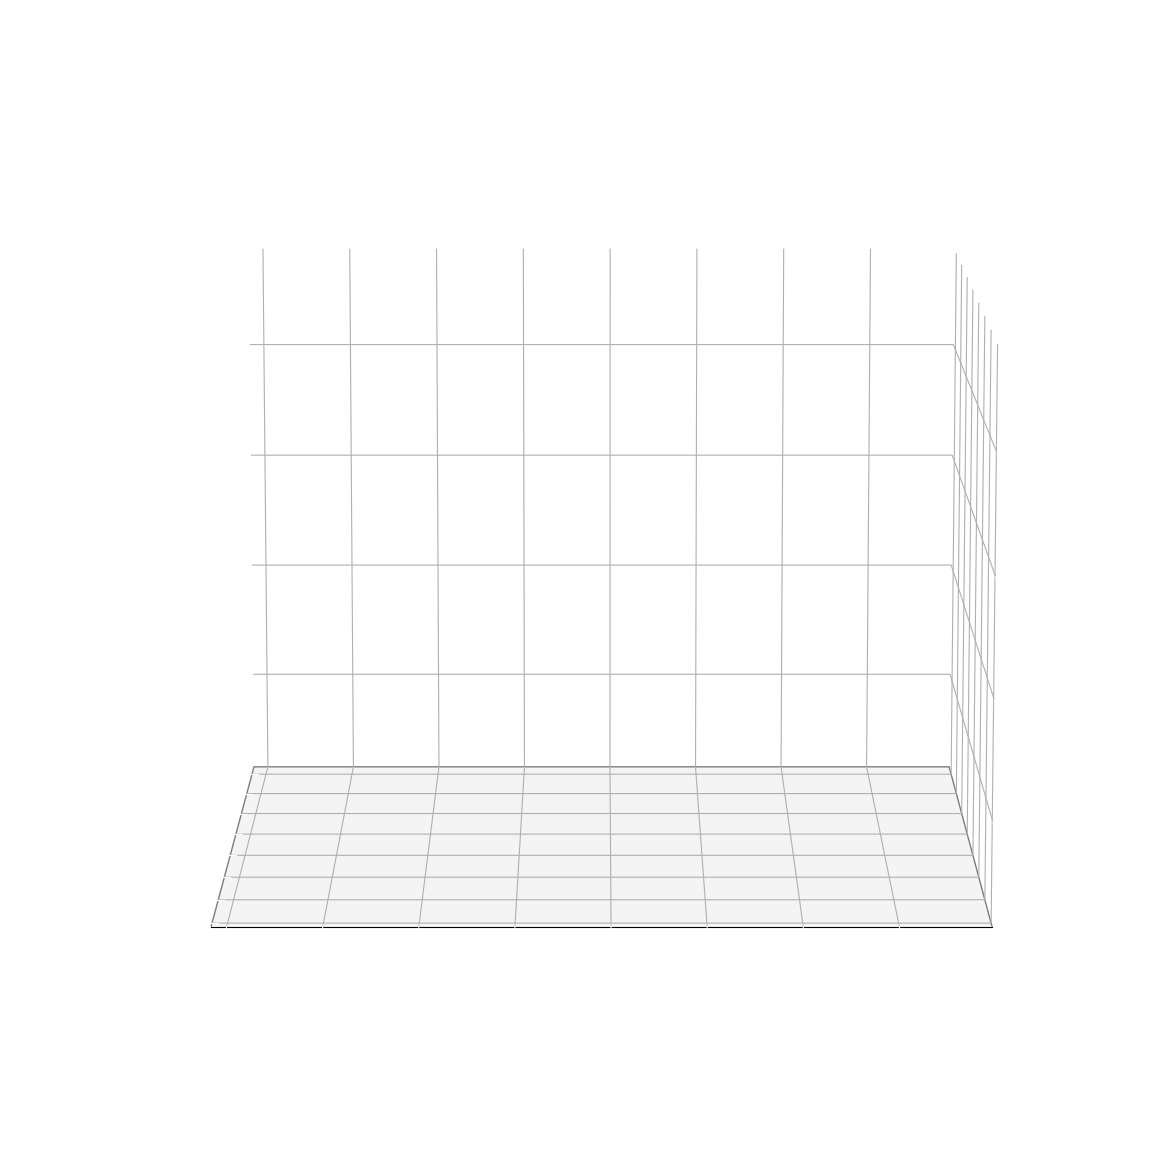

In [32]:
plt.close('all')
fig_reduced = plt.figure(figsize=(960/100, 720/100), dpi=100)

# Add a 3D subplot with the specified position and size
ax_reduced = fig_reduced.add_axes([-0.3, -0.2, 1.6, 1.6], projection='3d')
ax_reduced.view_init(elev=10, azim=180)


reducedMinMax = np.zeros((2,3))
reducedMinMax[0,:] = [reducedPosTableX.values.min(),reducedPosTableY.values.min(),reducedPosTableZ.values.min()]
reducedMinMax[1,:] = [reducedPosTableX.values.max(),reducedPosTableY.values.max(),reducedPosTableZ.values.max()]

# Set appropriate axis limits
ax_reduced.set_xlim([reducedMinMax[0,0],reducedMinMax[1,0]])
ax_reduced.set_ylim([reducedMinMax[0,1],reducedMinMax[1,1]])
ax_reduced.set_zlim([reducedMinMax[0,2],reducedMinMax[1,2]])


plt.rcParams['grid.color'] = 'white'
ax_reduced.tick_params(axis='both', colors='w')
# Remove box faces except the ground
ax_reduced.w_xaxis.pane.fill = False
ax_reduced.w_yaxis.pane.fill = False
ax_reduced.w_zaxis.pane.fill = True
ax_reduced.w_zaxis.pane.set_facecolor((0.92,.92,.92))
ax_reduced.xaxis.pane.set_edgecolor('w')
ax_reduced.yaxis.pane.set_edgecolor('w')
ax_reduced.zaxis.pane.set_edgecolor((0,0,0))
# Hide axis spines and ticks
ax_reduced.w_xaxis.line.set_visible(False)
ax_reduced.w_yaxis.line.set_visible(True)
ax_reduced.w_zaxis.line.set_visible(False) 

In [33]:
import cv2
#color_pool = ['#e31a1c', '#1f78b4', '#33a02c', '#ff7f00', '#6a3d9a', '#b15928']
color_pool = [(1,0.1,0.1),(0.1,1,0.1),(0.1,0.1,1),(1,1,0.1)]

def get_frame_reduced_skeleton_clustered(fig, ax, val, clusters,subtitle):
    ax.cla()  # Clear the previous plot
    
    # Filter the data based on the current time index
    filteredX = reducedPosTableX.iloc[val]
    filteredY = reducedPosTableY.iloc[val]
    filteredZ = reducedPosTableZ.iloc[val]
    
    ax.scatter(filteredX,filteredY,filteredZ,s=100,c=[color_pool[i] for i in clusters],alpha=1)

    # Add edges based on the weight matrix
    for i in range(len(adjacencyMatrix)):
        for j in range(i + 1, len(adjacencyMatrix)):
            if adjacencyMatrix[i,j]:
                ax.plot([filteredX[i], filteredX[j]],
                        [filteredY[i], filteredY[j]],
                        [filteredZ[i], filteredZ[j]],
                        color='k', linestyle='-', linewidth=1.5)

    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_zlim([reducedMinMax[0,2],reducedMinMax[1,2]])

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    frame = np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)
    frame = cv2.putText(frame, subtitle, ((frame.shape[1]-cv2.getTextSize(subtitle, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0][0])//2, frame.shape[0] - 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

    return frame

In [ ]:
from clustering import table_to_list_xyz_tables, group_table_by_joints, compute_derivatives, xyz_tables_to_xyz_columns, smoothing, joints_array_to_xyz_columns
import re

# Calculate angular momentum
if not os.path.isfile('_angmom.csv'): 
    dt = ((float(endSec)-float(startSec)) / len(reducedMarkersTable))
    centerOfMassPosTable = pd.concat([table.apply(lambda row: row.sum()/20,axis=1) for table in table_to_list_xyz_tables(reducedMarkersTable)],axis=1)
    relativePosTable = group_table_by_joints(xyz_tables_to_xyz_columns([posTableAxis.subtract(centerOfMassPosTable.iloc[:,j],axis=0) for j,posTableAxis in enumerate(table_to_list_xyz_tables(reducedMarkersTable))]))
    centerOfMassVelocityTable = compute_derivatives(centerOfMassPosTable,dt,smooth=False)
    relativeVelocityTable = group_table_by_joints(xyz_tables_to_xyz_columns([velocityTableAxis.subtract(centerOfMassVelocityTable.iloc[:,j],axis=0) for j,velocityTableAxis in enumerate(table_to_list_xyz_tables(compute_derivatives(reducedMarkersTable,dt)))]))
    angularMomentumTable = relativePosTable
    for i in range(len(relativePosTable)):
        for j in range(len(relativePosTable.columns)):
            angularMomentumTable.iloc[i,j][:] = np.cross(relativePosTable.iloc[i,j],relativeVelocityTable.iloc[i,j])
    angularMomentumTable = group_table_by_joints(smoothing(joints_array_to_xyz_columns(angularMomentumTable)))
    # Soooo long to recompute each time... better save a file
    angularMomentumTable.to_csv('_angmom.csv', index=False)
else:
    angularMomentumTable = pd.read_csv('_angmom.csv')
    angularMomentumTable = angularMomentumTable.applymap(lambda cell: np.array(eval(re.sub(r'(?<=[\d-])\s{1,}(?=[\d-])', ', ',cell))))


In [ ]:
import cv2
from tqdm.notebook import tqdm
import os
from clustering import *

# Create a VideoWriter object in OpenCV
full_hd = (1920,1080)
record = not os.path.isfile(video_path[:-4]+'_'+str(fps * 2)+'fps_clustered.mp4')
if record:
    out = cv2.VideoWriter(video_path[:-4]+'_'+str(fps * 2)+'fps_clustered.mp4', 
                          cv2.VideoWriter_fourcc(*'mp4v'), 
                          fps*2, 
                          full_hd)  # Adjust the filename, codec, frame rate, and frame size

vidcap = cv2.VideoCapture(video_path[:-4]+'_'+str(fps * 2)+'fps_360p.mp4')
filler_size = tuple(map(int,(vidcap.get(4),(full_hd[0]-vidcap.get(3))/2,3)))
filler = np.zeros(filler_size,dtype=np.uint8)+255
weightMatrix = calculate_weight_matrix(angularMomentumTable.iloc[0],adjacencyMatrix)
stabilized_labels = shi_malik_spectral_clustering_matlab_version(weightMatrix)
# Loop to update the plot and write frames to the video
for val in tqdm(range(len(fullMarkersTable)*(int(record)*2-1)),'Saving video',miniters=20):  # Replace total_frames with the actual number of frames
    ret, video_frame = vidcap.read()
    if not ret:
        break    
    weightMatrix = calculate_weight_matrix(angularMomentumTable.iloc[val],adjacencyMatrix)
    predicted_labels = shi_malik_spectral_clustering_matlab_version(weightMatrix)
    stabilized_labels = compute_minimum_weight_cluster(stabilized_labels,predicted_labels,'MWPM')
    # Draw an empty blue rectangle
    video_frame = cv2.rectangle(video_frame, (10, 10), (int(vidcap.get(3)-11), int(vidcap.get(4)-11)), (0, 0, 255), 2)
    video_frame = cv2.rectangle(video_frame, (0, 0), (int(vidcap.get(3)-2), int(vidcap.get(4)-2)), (127, 127, 127), 3)
    frame_clustered = cv2.cvtColor(get_frame_reduced_skeleton_clustered(fig_reduced, ax_reduced, val, predicted_labels,'Simple Clustering'), cv2.COLOR_RGB2BGR)
    frame_clustered_stabilized = cv2.cvtColor(get_frame_reduced_skeleton_clustered(fig_reduced, ax_reduced, val, stabilized_labels,'Stabilized Clustering'), cv2.COLOR_RGB2BGR)
    out.write(np.vstack((np.hstack((filler,video_frame,filler)), np.hstack((frame_clustered,frame_clustered_stabilized)))))

# Release the VideoWriter and close the OpenCV window (if used)
if record:
    out.release()
vidcap.release()
#plt.close('all')

# VISUALIZATION

In [ ]:
import networkx as nx

skeleton_graph = nx.from_numpy_array(adjacencyMatrix)
leaf_nodes = [node for node in skeleton_graph.nodes() if skeleton_graph.degree(node) == 1]

def smooth_clusters_VBase(previous_clusters:list, current_clusters:list,weightMatrix,i:int=0, delay:int=-1):
    if delay <= 0 or i % delay != 0:
        return previous_clusters

    # Compute the frontier of the previous clusters for every cluster
    frontier_nodes = { cluster_id: {
                        neighbor
                        for node in nodes
                        for neighbor in skeleton_graph.neighbors(node)
                        if neighbor not in nodes
                        }
                        for cluster_id, nodes in {key: set([i for i, val in enumerate(previous_clusters) if val == key]) 
                                                    for key in set(previous_clusters)}.items()
                     }
    
    # Update only clusters whose nodes are at the frontier of each cluster
    new_clusters = { node: cluster_id
                     for cluster_id in set(previous_clusters)
                     for node in frontier_nodes[cluster_id]
                     if current_clusters[node] == cluster_id }

    # Add remaining nodes and update the leaf nodes (to avoid cluster disappearing)
    new_clusters.update({ node: current_clusters[node] if not node in new_clusters else cluster_id
                            for node, cluster_id in enumerate(previous_clusters) })
    
    # TODO further improvement may implement the possibility to choose the node from which the
    # cluster should fade in, based on the weakest similarity value
    return [cluster_id for _,cluster_id in sorted(new_clusters.items())]

In [35]:
import networkx as nx

skeleton_graph = nx.from_numpy_array(adjacencyMatrix)
leaf_nodes = [node for node in skeleton_graph.nodes() if skeleton_graph.degree(node) == 1]

def smooth_clusters(previous_clusters: list, current_clusters: list, weightMatrix, i: int = 0, delay: int = -1):
    if delay <= 0 or i % delay != 0:
        return previous_clusters

    # Step 1: Create dictionaries for current and previous clusters
    current_clusters_dict = {cluster_id: [node for node, cluster in enumerate(current_clusters) if cluster == cluster_id] for cluster_id in set(current_clusters)}
    previous_clusters_dict = {cluster_id: [node for node, cluster in enumerate(previous_clusters) if cluster == cluster_id] for cluster_id in set(previous_clusters)}

    # Step 2: Subtract current cluster dictionary from previous clusters
    changed_clusters = {cluster_id: list(set(current_clusters_dict[cluster_id]) - set(previous_clusters_dict.get(cluster_id, [])) ) for cluster_id in current_clusters_dict}

    # Step 3: Sort nodes by decreasing weighted degree centrality, grouped by cluster
    sorted_nodes_by_centrality = {
        cluster_id: [node for node, _ in sorted({node: sum(weightMatrix[node][neighbor] for neighbor in nodes) 
                                                 for node in nodes}.items(), key=lambda x: x[1], reverse=True)]
        for cluster_id, nodes in changed_clusters.items()}

    # Step 4: Update one node with the highest weighted degree centrality for each cluster
    out_clusters = {sorted_nodes[0]: cluster_id for cluster_id, sorted_nodes in sorted_nodes_by_centrality.items() if sorted_nodes}


    out_clusters.update({ node: cluster_id for node, cluster_id in enumerate(previous_clusters) if not node in out_clusters })

    return [cluster_id for _,cluster_id in sorted(out_clusters.items())]


In [ ]:
import cv2
from tqdm.notebook import tqdm
import os
from clustering import *
import warnings
warnings.filterwarnings("ignore", category=Warning)

# Create a VideoWriter object in OpenCV
full_hd = (1920,1080)
record = not os.path.isfile(video_path[:-4]+'_'+str(fps * 2)+'fps_clustered_delayed.mp4')
if record:
    out = cv2.VideoWriter(video_path[:-4]+'_'+str(fps * 2)+'fps_clustered_delayed.mp4', 
                          cv2.VideoWriter_fourcc(*'mp4v'), 
                          fps*2, 
                          full_hd)  # Adjust the filename, codec, frame rate, and frame size

vidcap = cv2.VideoCapture(video_path[:-4]+'_'+str(fps * 2)+'fps_360p.mp4')
filler_size = tuple(map(int,(vidcap.get(4),(full_hd[0]-vidcap.get(3))/2,3)))
filler = np.zeros(filler_size,dtype=np.uint8)+255
weightMatrix = calculate_weight_matrix(angularMomentumTable.iloc[0],adjacencyMatrix)
stabilized_labels = shi_malik_spectral_clustering_matlab_version(weightMatrix)
stabilized_smoothed_labels = stabilized_labels

# Loop to update the plot and write frames to the video
for val in tqdm(range(len(fullMarkersTable)*(int(record)*2-1)),'Saving video',miniters=20):  # Replace total_frames with the actual number of frames
    ret, video_frame = vidcap.read()
    if not ret:
        break    
    weightMatrix = calculate_weight_matrix(angularMomentumTable.iloc[val],adjacencyMatrix)
    predicted_labels = shi_malik_spectral_clustering_matlab_version(weightMatrix)
    stabilized_labels = compute_minimum_weight_cluster(stabilized_labels,predicted_labels,'MWPM')
    stabilized_smoothed_labels = smooth_clusters(stabilized_smoothed_labels,stabilized_labels,weightMatrix,val,fps//4)

    # Draw an empty blue rectangle
    video_frame = cv2.rectangle(video_frame, (10, 10), (int(vidcap.get(3)-11), int(vidcap.get(4)-11)), (0, 0, 255), 2)
    video_frame = cv2.rectangle(video_frame, (0, 0), (int(vidcap.get(3)-2), int(vidcap.get(4)-2)), (127, 127, 127), 3)
    frame_clustered = cv2.cvtColor(get_frame_reduced_skeleton_clustered(fig_reduced, ax_reduced, val, stabilized_labels,'Stabilized Clustering'), cv2.COLOR_RGB2BGR)
    frame_clustered_stabilized = cv2.cvtColor(get_frame_reduced_skeleton_clustered(fig_reduced, ax_reduced, val, stabilized_smoothed_labels,'Stabilized Smoothed'), cv2.COLOR_RGB2BGR)
    #frame_clustered_stabilized = cv2.putText(frame_clustered_stabilized, str(val), (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    out.write(np.vstack((np.hstack((filler,video_frame,filler)), np.hstack((frame_clustered,frame_clustered_stabilized)))))

# Release the VideoWriter and close the OpenCV window (if used)
if record:
    out.release()
vidcap.release()

In [56]:
from tqdm.notebook import tqdm

red = (1,0.5,0.5)
green = (0.5,1,0.5)
blue = (68/255,114/255,196/255)
colors_map = {0:red,1:green,2:blue}

dynamic_colors = np.array([blue]*20)

val = 700
rate = 1
frames = 120


weightMatrix = calculate_weight_matrix(angularMomentumTable.iloc[val],adjacencyMatrix)
plt.imsave('_imgs/unclusterized/unclusterized_'+str(i)+'.png', get_frame_reduced_skeleton(fig_reduced,ax_reduced,val+rate))
standard_labels = shi_malik_spectral_clustering_matlab_version(weightMatrix,3)
plt.imsave('_imgs/pure/pure_t.png',get_frame_reduced_skeleton_clustered(fig_reduced, ax_reduced, val, standard_labels,'t = '+str(val)[0]+'.'+str(val)[1:]))
stabilized_smoothed_labels = standard_labels
stabilized_labels = standard_labels
for i in tqdm(range(frames),"Saving frames"):
    weightMatrix = calculate_weight_matrix(angularMomentumTable.iloc[val],adjacencyMatrix)
    standard_labels = shi_malik_spectral_clustering_matlab_version(weightMatrix,3)
    weightMatrix = calculate_weight_matrix(angularMomentumTable.iloc[val+rate],adjacencyMatrix)
    standard_labels_next = shi_malik_spectral_clustering_matlab_version(weightMatrix,3)
    stabilized_labels = compute_minimum_weight_cluster(stabilized_labels,standard_labels_next)

    plt.imsave('_imgs/unclusterized/unclusterized_'+str(i)+'.png', get_frame_reduced_skeleton(fig_reduced,ax_reduced,val+rate))

    plt.imsave('_imgs/pure/pure_next_'+str(i)+'.png',get_frame_reduced_skeleton_clustered(fig_reduced, ax_reduced, val+rate, standard_labels_next,'t = '+str(val+rate)[0]+'.'+str(val+rate)[1:]))
    #print(standard_labels)
    #print(standard_labels_next)
    #print(compute_minimum_weight_cluster(standard_labels,standard_labels_next,'MWPM'))
    #print(list(stabilized_smoothed_labels))
    plt.imsave('_imgs/stabilized/stabilized_next_'+str(i)+'.png',get_frame_reduced_skeleton_clustered(fig_reduced, ax_reduced, val+rate, stabilized_labels,'t = '+str(val+rate)[0]+'.'+str(val+rate)[1:]))

    stabilized_smoothed_labels = smooth_clusters(stabilized_smoothed_labels,stabilized_labels,weightMatrix,i,5)
    plt.imsave('_imgs/smoothed/smoothed_next_'+str(i)+'.png',get_frame_reduced_skeleton_clustered(fig_reduced, ax_reduced, val+rate, stabilized_smoothed_labels,'t = '+str(val+rate)[0]+'.'+str(val+rate)[1:]))
    val += rate


Saving frames:   0%|          | 0/120 [00:00<?, ?it/s]

/tmp/ipykernel_5181/1817067418.py:19: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  cluster_id: [node for node, _ in sorted({node: sum(weightMatrix[node][neighbor] for neighbor in nodes)
/tmp/ipykernel_5181/1817067418.py:19: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  cluster_id: [node for node, _ in sorted({node: sum(weightMatrix[node][neighbor] for neighbor in nodes)
/tmp/ipykernel_5181/1817067418.py:19: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  cluster_id: [node for node, _ in sorted({node: sum(weightMatrix[node][neighbor] for neighbor in nodes)
/tmp/ipykernel_5181/1817067418.py:

In [68]:
from PIL import Image
import os

# List of image files
image_files = []  # Replace with your file names
for i in range(frames):
    #image_files.append('_imgs/pure/pure_next_'+str(i)+'.png')
    image_files.append('_imgs/unclusterized/unclusterized_'+str(i)+'.png')

# Create a list to store the images
images = []

# Load each image and append it to the list
for image_file in image_files:
    img = Image.open(image_file)
    images.append(img)


# Set the path for the output GIF
output_gif = '_unclusterized.gif'

# Save the list of images as a GIF
Image.open(image_files[0]).save(output_gif, format='GIF', save_all=True, append_images=images[1:],duration=0.01,loop=0,quality=50)

# Clean up (optional): delete the individual image files if needed
#for image_file in image_files:
#    os.remove(image_file)

print(f'GIF saved as {output_gif}')



from PIL import Image

# Open the GIF
input_gif = '_unclusterized.gif'
input_images = []

with Image.open(input_gif) as img:
    
    # Crop each frame
    for i in range(img.n_frames):
        img.seek(i)
        cropped_img = img.crop((420, 250, img.width-370, img.height-20))
        input_images.append(cropped_img)
for i in range(img.n_frames):
    input_images.append(input_images[img.n_frames-i-1])

# Save the cropped images as a new GIF
output_cropped_gif = '_unclusterized_cropped.gif'
input_images[0].save(output_cropped_gif, format='GIF', save_all=True, append_images=input_images[1:], duration=0.01, loop=0, quality=50)
print(f'GIF cropped and saved as {output_cropped_gif}')


GIF saved as _unclusterized.gif
GIF cropped and saved as _unclusterized_cropped.gif


In [69]:
from PIL import Image
import os

# List of image files
image_files = []  # Replace with your file names
for i in range(frames):
    image_files.append('_imgs/pure/pure_next_'+str(i)+'.png')

# Create a list to store the images
images = []

# Load each image and append it to the list
for image_file in image_files:
    img = Image.open(image_file)
    images.append(img)


# Set the path for the output GIF
output_gif = '_pure.gif'

# Save the list of images as a GIF
Image.open(image_files[0]).save(output_gif, format='GIF', save_all=True, append_images=images[1:],duration=1,loop=0,quality=20)

# Clean up (optional): delete the individual image files if needed
#for image_file in image_files:
#    os.remove(image_file)

print(f'GIF saved as {output_gif}')



from PIL import Image

# Open the GIF
input_gif = '_pure.gif'
input_images = []

with Image.open(input_gif) as img:
    
    # Crop each frame
    for i in range(img.n_frames):
        img.seek(i)
        cropped_img = img.crop((420, 250, img.width-370, img.height-20))
        input_images.append(cropped_img.copy())
for i in range(img.n_frames):
    input_images.append(input_images[img.n_frames-i-1])

# Save the cropped images as a new GIF
output_cropped_gif = '_pure_cropped.gif'
input_images[0].save(output_cropped_gif, format='GIF', save_all=True, append_images=input_images[1:], duration=0.01, loop=0, quality=20)
print(f'GIF cropped and saved as {output_cropped_gif}')


GIF saved as _pure.gif
GIF cropped and saved as _pure_cropped.gif


In [70]:
from PIL import Image
import os

# List of image files
image_files = []  # Replace with your file names
for i in range(frames):
    image_files.append('_imgs/stabilized/stabilized_next_'+str(i)+'.png')

# Create a list to store the images
images = []

# Load each image and append it to the list
for image_file in image_files:
    img = Image.open(image_file)
    images.append(img)


# Set the path for the output GIF
output_gif = '_stabilized.gif'

# Save the list of images as a GIF
Image.open(image_files[0]).save(output_gif, format='GIF', save_all=True, append_images=images[1:],duration=1,loop=0,quality=20)

# Clean up (optional): delete the individual image files if needed
#for image_file in image_files:
#    os.remove(image_file)

print(f'GIF saved as {output_gif}')



from PIL import Image

# Open the GIF
input_gif = '_stabilized.gif'
input_images = []

with Image.open(input_gif) as img:
    
    # Crop each frame
    for i in range(img.n_frames):
        img.seek(i)
        cropped_img = img.crop((420, 250, img.width-370, img.height-20))
        input_images.append(cropped_img.copy())
for i in range(img.n_frames):
    input_images.append(input_images[img.n_frames-i-1])

# Save the cropped images as a new GIF
output_cropped_gif = '_stabilized_cropped.gif'
input_images[0].save(output_cropped_gif, format='GIF', save_all=True, append_images=input_images[1:], duration=0.01, loop=0, quality=20)
print(f'GIF cropped and saved as {output_cropped_gif}')


GIF saved as _stabilized.gif
GIF cropped and saved as _stabilized_cropped.gif


In [71]:
from PIL import Image
import os

# List of image files
image_files = []  # Replace with your file names
for i in range(frames):
    image_files.append('_imgs/smoothed/smoothed_next_'+str(i)+'.png')

# Create a list to store the images
images = []

# Load each image and append it to the list
for image_file in image_files:
    img = Image.open(image_file)
    images.append(img)


# Set the path for the output GIF
output_gif = '_smoothed.gif'

# Save the list of images as a GIF
Image.open(image_files[0]).save(output_gif, format='GIF', save_all=True, append_images=images[1:],duration=1,loop=0,quality=20)

# Clean up (optional): delete the individual image files if needed
#for image_file in image_files:
#    os.remove(image_file)

print(f'GIF saved as {output_gif}')



from PIL import Image

# Open the GIF
input_gif = '_smoothed.gif'
input_images = []

with Image.open(input_gif) as img:

    # Crop each frame
    for i in range(img.n_frames):
        img.seek(i)
        cropped_img = img.crop((420, 250, img.width-370, img.height-20))
        input_images.append(cropped_img.copy())
for i in range(img.n_frames):
    input_images.append(input_images[img.n_frames-i-1])

# Save the cropped images as a new GIF
output_cropped_gif = '_smoothed_cropped.gif'
input_images[0].save(output_cropped_gif, format='GIF', save_all=True, append_images=input_images[1:], duration=0.01, loop=0, quality=20)
print(f'GIF cropped and saved as {output_cropped_gif}')


GIF saved as _smoothed.gif
GIF cropped and saved as _smoothed_cropped.gif


In [ ]:
import cv2
from PIL import Image
import os

# List of image files
image_files = []  # Replace with your file names
for i in range(frames):
    image_files.append('_imgs/stabilized/stabilized_next_'+str(i)+'.png')

img = cv2.imread(image_files[0])

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for video output
output_video = cv2.VideoWriter('stabilized_video.mp4', fourcc, 100, (img.shape[1], img.shape[0]))  # Set FPS as 30

# Loop through the images and write to video
for image_file in image_files:
    img = cv2.imread(image_file)
    output_video.write(img)

# Release VideoWriter and close windows
output_video.release()

In [ ]:
import cv2
import os

# List of image files
image_files = []  # Replace with your file names
for i in range(frames):
    image_files.append('_imgs/stabilized/stabilized_next_' + str(i) + '.png')

img = cv2.imread(image_files[0])

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for video output
output_video = cv2.VideoWriter('stabilized_video_modified.mp4', fourcc, 100, (img.shape[1], img.shape[0] * 9 // 10 - 140))  # Set FPS as 100
print(img.shape)

# Loop through the images, modify height, and write to video
for image_file in image_files:
    img = cv2.imread(image_file)
    new_height = img.shape[0] * 9 // 10  # Calculate new height
    img_resized = img[140:new_height,:img.shape[1]]  # Resize image
    output_video.write(img_resized)

# Release VideoWriter and close windows
output_video.release()


In [ ]:
import cv2
from PIL import Image
import os

# List of image files
image_files = []  # Replace with your file names
for i in range(300):
    image_files.append('_imgs/smoothed/smoothed_next_'+str(i)+'.png')

img = cv2.imread(image_files[0])

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for video output
output_video = cv2.VideoWriter('smoothed_video.mp4', fourcc, 100, (img.shape[1], img.shape[0]))  # Set FPS as 30

# Loop through the images and write to video
for image_file in image_files:
    img = cv2.imread(image_file)
    output_video.write(img)

# Release VideoWriter and close windows
output_video.release()

In [ ]:
import cv2
from PIL import Image
import os

# List of image files
image_files = []  # Replace with your file names
for i in range(300):
    image_files.append('_imgs/pure/pure_next_'+str(i)+'.png')

img = cv2.imread(image_files[0])

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for video output
output_video = cv2.VideoWriter('pure_video.mp4', fourcc, 100, (img.shape[1], img.shape[0]))  # Set FPS as 30

# Loop through the images and write to video
for image_file in image_files:
    img = cv2.imread(image_file)
    output_video.write(img)

# Release VideoWriter and close windows
output_video.release()

In [8]:
import qrcode

# URL
link = "https://raw.githubusercontent.com/gaggioaxel/OoM-Thesis/d77a670b2e8bd94db590bf3ed9b12758b35d4672/docs/thesis/graphics/visualization_clustering.gif"
link = "https://raw.githubusercontent.com/gaggioaxel/OoM-Thesis/d77a670b2e8bd94db590bf3ed9b12758b35d4672/docs/thesis/graphics/visualization_stabilized.gif"
link = "https://raw.githubusercontent.com/gaggioaxel/OoM-Thesis/d77a670b2e8bd94db590bf3ed9b12758b35d4672/docs/thesis/graphics/visualization_smoothed.gif"

# Generate QR code
qr = qrcode.QRCode(version=1, box_size=10, border=5)
qr.add_data(link)
qr.make(fit=True)

img = qr.make_image(fill_color="black", back_color="white")

# Save QR code image
img.save("_qrcode_smoothed.png")  # Save as PNG file
